In [1]:
# standard imports
from __future__ import annotations
import os
from typing import Any

import dask_image.ndfilters
import numpy as np
import napari
import ipynbname
import matplotlib as mpl
import matplotlib.dates
import matplotlib.ticker
import matplotlib.pyplot as plt
import ants
import pandas as pd
import seaborn as sns
import skimage as ski
import h5py
import scipy
import binascii
import glob
import itertools as it

# local imports
import prairie_view_imports as pvi
import c_swain_python_utils as csutils
from utilities import *
import tiff_utils as tifu
import imaging_dataset as imd

sns.set_style('ticks')

_file = ipynbname.path()
_name = csutils.no_ext_basename(_file)
jobs_dir = os.path.split(_file)[0]
sources_dir = os.path.abspath(os.path.join(jobs_dir, '..'))
repo_dir = os.path.abspath(os.path.join(sources_dir, '..'))
config_dir = os.path.abspath(os.path.join(repo_dir, 'configs'))

In [2]:
# LOGGER
log = csutils.get_logger(_name)

# - logging setup
debug_mode = False
default_window_level = 'info'

# setup logging
log_path = os.path.join(sources_dir, '..', 'logs', f'{_file}.log')
csutils.apply_standard_logging_config(
    file_path=None,
    window_level='debug' if debug_mode else default_window_level,
    window_format='debug' if debug_mode else 'default')

In [3]:
log.info('Loading Config...')
config_name = 'cs-ii-29_config'
config_path = os.path.join(config_dir, f'{config_name}.yml')
config = ZMIAConfig(config_path)

desired_run = 399

log.info('Loading dataset information objects for run {}',
         desired_run)

live_2p_dsi = config.get_dataset_info(
    run=desired_run,
    type='two-photon')
stitch_cf_dsi = config.get_dataset_info(name='fish-29B_stitched-gcamp-stain')
control_dsi = config.get_dataset_info(
    run=desired_run,
    type='stimulation-control-log')
sensor_dsi = config.get_dataset_info(
    run=desired_run,
    type='stimulation-sensor-log')
zz_output_dsi = config.get_dataset_info(
    run=desired_run,
    type='zebrazoom-output')
behav_cam_dsi = config.get_dataset_info(
    run=desired_run,
    type='behavioral-cam')

local-nb_cs-ii-29_import-tests (   1): INFO : Loading Config...
local-nb_cs-ii-29_import-tests (   8): INFO : Loading dataset information objects for run 399


# Stiched Confocal Data

In [4]:
log.info('Importing tiff and converting to ImagingDataset ...')
cf_imds = imd.ImagingDataset.from_dataset_info(stitch_cf_dsi)

local-nb_cs-ii-29_import-tests (   1): INFO : Importing tiff and converting to ImagingDataset ...
tiff_utils ( 109): INFO : Loading all image data from tiff file at "G:\c_swain\zf_correlative_microscopy\raw_data\cs-ii-29_confocal_20230825\fish-B\STITCH_fish-B_high-res-stack_6-pos_460-z_1-chan_021_v3.tif".


imaging_dataset ( 901): WARNING : Assuming dimension order for tiff with 3 dimensions is (Dim('z'), Dim('y'), Dim('x')). 


imaging_dataset ( 687): INFO : Attempting to load imaging dataset from cache.


In [ ]:
log.info('Pulling image data ndarray...')
cf_im_ndarray = cf_imds.get_image_data() 

In [ ]:
log.info('Misc ndarray and dataset information: ')
log.info(f'{cf_imds.coordinates = }')
log.info(f'{cf_im_ndarray.shape = }')
log.info(f'{cf_im_ndarray.dtype = }')
log.info(f'{(np.min(cf_im_ndarray), np.max(cf_im_ndarray)) = }')

In [ ]:
viewer = napari.Viewer()
cf_imds.add_to_napari(napari_viewer=viewer)
imd.ImagingDataset.apply_standard_napari_config(viewer)
napari.run()

# Live 2P Data

In [5]:
live_imds = imd.ImagingDataset.from_dataset_info(live_2p_dsi)

prairie_view_imports (2745): INFO : Loading dataset (two-photon-fish-29B_run-399_2p-tz) from config cs-ii-29_2p-recordings.
prairie_view_imports (1534): INFO : Attempting to load dataset from cache.
prairie_view_imports (1551): INFO : Loading of dataset from cache was successful.
prairie_view_imports (1564): INFO : Loading in cached images.
prairie_view_imports (1572): INFO : Loading in of cached images is sucessful.
imaging_dataset (1039): INFO : Categorized PVDataset as PVDatasetCategory.Z_STACK_IMAGE|TZ_SERIES_IMAGE|MULTI_SEQUENCE
imaging_dataset (1046): INFO : Initializing ImagingDataset(s) from prairie view dataset PVDataset(name='two-photon-fish-29B_run-399_2p-tz', num_sequences=1710)
imaging_dataset ( 687): INFO : Attempting to load imaging dataset from cache.


In [6]:
log.info(f'{live_imds.source_data.metadata[pvi.pvmk.OBJECTIVE_LENS] = }')

local-nb_cs-ii-29_import-tests (   1): INFO : live_imds.source_data.metadata[pvi.pvmk.OBJECTIVE_LENS] = '16x Nikon'


In [6]:
viewer = napari.Viewer()
imd.ImagingDataset.apply_standard_napari_config(viewer)
live_imds.add_to_napari(napari_viewer=viewer)
napari.run()

Drop problematic z frames

In [7]:
if 'z-index-to-ignore' in live_2p_dsi:
    live_imds_drop = live_imds.drop_slices(
        slice_indexes=live_2p_dsi['z-index-to-ignore'],                                       
        axis=Dim.Z)
else:
    live_imds_drop = live_imds

imaging_dataset ( 401): INFO : Performing the following operation on ImagingDataset(name='two-photon-fish-29B_run-399_2p-tz', shape=(1710, 20, 362, 512)) and returning a new ImagingDataset:
imaging_dataset ( 405): INFO : > __getitem__(*[(slice(None, None, None), [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], slice(None, None, None), slice(None, None, None))], **{})


In [8]:
log.info(f'{live_imds.shape = }')
log.info(f'{live_imds_drop.shape = }')

log.info(f'{live_imds.coordinates[Dim.Z] = }')
log.info(f'{live_imds_drop.coordinates[Dim.Z] = }')

local-nb_cs-ii-29_import-tests (   1): INFO : live_imds.shape = (1710, 20, 362, 512)
local-nb_cs-ii-29_import-tests (   2): INFO : live_imds_drop.shape = (1710, 18, 362, 512)
local-nb_cs-ii-29_import-tests (   4): INFO : live_imds.coordinates[Dim.Z] = Coord([128.6, ...], len=20, unit='micrometer')
local-nb_cs-ii-29_import-tests (   5): INFO : live_imds_drop.coordinates[Dim.Z] = Coord([155.96842105263198, ...], len=18, unit='micrometer')


## Max Projection through Time

In [9]:
live_im_ndarray = live_imds_drop.get_image_data()

In [10]:
log.info(f'{live_imds_drop.axis_dict = }')
log.info(f'{live_imds_drop.shape_dict = }')

local-nb_cs-ii-29_import-tests (   1): INFO : live_imds_drop.axis_dict = {Dim('time'): 0, Dim('z'): 1, Dim('y'): 2, Dim('x'): 3}
local-nb_cs-ii-29_import-tests (   2): INFO : live_imds_drop.shape_dict = {Dim('time'): 1710, Dim('z'): 18, Dim('y'): 362, Dim('x'): 512}


In [11]:
log.info('Taking max projection of dataset through time.')
live_max_proj_ds = live_imds_drop.apply(np.max, axis=Dim.TIME)

local-nb_cs-ii-29_import-tests (   1): INFO : Taking max projection of dataset through time.
imaging_dataset ( 401): INFO : Performing the following operation on ImagingDataset(name='__GETITEM__(5273869fd1a8268)-two-photon-fish-29B_run-399_2p-tz', shape=(1710, 18, 362, 512)) and returning a new ImagingDataset:
imaging_dataset ( 405): INFO : > numpy.max(*(), **{'axis': 0})


In [12]:
log.info(f'{live_max_proj_ds.op_history = }')
log.info(f'{live_max_proj_ds.name = }')
log.info(f'{live_max_proj_ds.coordinates = }')
log.info(f'{live_max_proj_ds.shape_dict = }')
log.info(f'{live_max_proj_ds.coordinates = }')
log.info(f'{live_max_proj_ds.scale_dict = }')

local-nb_cs-ii-29_import-tests (   1): INFO : live_max_proj_ds.op_history = ['__getitem__(*[(slice(None, None, None), [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], slice(None, None, None), slice(None, None, None))], **{})', "numpy.max(*(), **{'axis': 0})"]
local-nb_cs-ii-29_import-tests (   2): INFO : live_max_proj_ds.name = 'MAX(65bc65eebcaf0c34)-__GETITEM__(5273869fd1a8268)-two-photon-fish-29B_run-399_2p-tz'
local-nb_cs-ii-29_import-tests (   3): INFO : live_max_proj_ds.coordinates = {Dim('x'): Coord([-411.2052837414497, ...], len=512, unit='micrometer'), Dim('y'): Coord([-285.4456309797717, ...], len=362, unit='micrometer'), Dim('z'): Coord([155.96842105263198, ...], len=18, unit='micrometer')}
local-nb_cs-ii-29_import-tests (   4): INFO : live_max_proj_ds.shape_dict = {Dim('z'): 18, Dim('y'): 362, Dim('x'): 512}
local-nb_cs-ii-29_import-tests (   5): INFO : live_max_proj_ds.coordinates = {Dim('x'): Coord([-411.2052837414497, ...], len=512, unit='micrometer'), Di

In [72]:
viewer = napari.Viewer()
live_max_proj_ds.add_to_napari(viewer)
imd.ImagingDataset.apply_standard_napari_config(viewer)
napari.run()

# Z-Brain Atlas

In [13]:
log.info('Loading Atlas Config...')
ref_config = ZMIAConfig(os.path.join(config_dir, 'no-nb-ref_config_z-brain-atlas.yml'))

local-nb_cs-ii-29_import-tests (   1): INFO : Loading Atlas Config...


In [14]:
# TODO - look for atlas data on NESE
log.info('Loading Atlas Dataset...')
ref_ds = imd.ImagingDataset.from_dataset_info(ref_config.get_dataset_info(name='h2b-rfp-brain'))

local-nb_cs-ii-29_import-tests (   2): INFO : Loading Atlas Dataset...
tiff_utils ( 109): INFO : Loading all image data from tiff file at "G:\c_swain\zf_correlative_microscopy\ref_data\z-brain-atlas\Elavl3-H2BRFP.tif".


imaging_dataset ( 901): WARNING : Assuming dimension order for tiff with 3 dimensions is (Dim('z'), Dim('y'), Dim('x')). 


imaging_dataset ( 687): INFO : Attempting to load imaging dataset from cache.


In [15]:
log.info('Applying transforms to reference dataset')
ref_ds_prime = ref_ds.flip(axis=Dim.Z)
ref_ds_prime = ref_ds_prime.rot90(axis=Dim.Z, k=0)

local-nb_cs-ii-29_import-tests (   1): INFO : Applying transforms to reference dataset
imaging_dataset ( 401): INFO : Performing the following operation on ImagingDataset(name='confocal-h2b-rfp-brain', shape=(138, 621, 1406)) and returning a new ImagingDataset:
imaging_dataset ( 405): INFO : > numpy.flip(*(), **{'axis': 0})
imaging_dataset ( 401): INFO : Performing the following operation on ImagingDataset(name='FLIP(4660035f8c866ad6)-confocal-h2b-rfp-brain', shape=(138, 621, 1406)) and returning a new ImagingDataset:
imaging_dataset ( 405): INFO : > numpy.rot90(*(), **{'k': 0, 'axes': (1, 2)})


imaging_dataset ( 320): WARNING : position data attribute may be out of date after rotation (proper handling not yet implemented).


In [16]:
log.info(f'{ref_ds_prime.name = }')
log.info(f'{ref_ds_prime.coordinates = }')
log.info(f'{ref_ds_prime.op_history = }')

local-nb_cs-ii-29_import-tests (   1): INFO : ref_ds_prime.name = 'ROT90(2be9946befbfe430)-FLIP(4660035f8c866ad6)-confocal-h2b-rfp-brain'
local-nb_cs-ii-29_import-tests (   2): INFO : ref_ds_prime.coordinates = {Dim('z'): Coord([0.0, ...], len=138, unit='micrometer'), Dim('y'): Coord([0.0, ...], len=621, unit='micrometer'), Dim('x'): Coord([0.0, ...], len=1406, unit='micrometer')}
local-nb_cs-ii-29_import-tests (   3): INFO : ref_ds_prime.op_history = ["numpy.flip(*(), **{'axis': 0})", "numpy.rot90(*(), **{'k': 0, 'axes': (1, 2)})"]


In [21]:
viewer = napari.Viewer()
ref_ds_prime.add_to_napari(viewer)
live_max_proj_ds.add_to_napari(viewer)
imd.ImagingDataset.apply_standard_napari_config(viewer)
napari.run()

in_n_out ( 768): DEBUG : Executing @injected ViewerToggleAction.__init__.<locals>.get_current(viewer: napari.viewer.Viewer) with args: (), kwargs: {}
in_n_out ( 787): DEBUG :   injecting viewer: <class 'napari.viewer.Viewer'> = Viewer(camera=Camera(center=(0.0, 0.0, 0.0), zoom=1.0, angles=(0.0, 0.0, 90.0), perspective=0.0, mouse_pan=True, mouse_zoom=True), cursor=Cursor(position=(1.0, 1.0), scaled=True, size=1, style=<CursorStyle.STANDARD: 'standard'>), dims=Dims(ndim=2, ndisplay=2, last_used=0, range=((0, 2, 1), (0, 2, 1)), current_step=(0, 0), order=(0, 1), axis_labels=('0', '1')), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[], help='', status='Ready', tooltip=Tooltip(visible=False, text=''), theme='dark', title='napari', mouse_over_canvas=False, mouse_move_callbacks=[], mouse_drag_callbacks=[], mouse_double_click_callbacks=[], mouse_wheel_callbacks=[<function dims_scroll at 0x00000266245D5C10>], _persisted_mouse_event={}, _mouse_drag_gen={}, _mouse_wheel_gen={}

# Registration Implementation

First choose images for registration

In [17]:
moving_imds = live_max_proj_ds
fixed_imds = ref_ds_prime

In [18]:
moving_scale = np.abs(moving_imds.scale)
log.info(f'{moving_scale = }')
moving_im_raw = live_max_proj_ds.get_image_data()

fixed_scale = np.abs(fixed_imds.scale)
log.info(f'{fixed_scale = }')
fixed_im_raw = ref_ds_prime.get_image_data()

min_scale = np.min([moving_scale, fixed_scale], axis=0)
log.info(f'{min_scale = }')

moving_rescale_factor = moving_scale / min_scale
fixed_rescale_factor = fixed_scale / min_scale
log.info(f'{moving_rescale_factor = }')
log.info(f'{fixed_rescale_factor = }')

moving_new_shape = np.round(np.array(moving_imds.shape) * moving_rescale_factor)
fixed_new_shape = np.round(np.array(fixed_imds.shape) * fixed_rescale_factor)
log.info(f'{moving_imds.shape = }')
log.info(f'{moving_new_shape = }')
log.info(f'{fixed_imds.shape = }')
log.info(f'{fixed_new_shape = }')

local-nb_cs-ii-29_import-tests (   2): INFO : moving_scale = array([13.68421053,  1.6069287 ,  1.6069287 ])
local-nb_cs-ii-29_import-tests (   6): INFO : fixed_scale = array([2.       , 0.7980005, 0.7980005])
local-nb_cs-ii-29_import-tests (  10): INFO : min_scale = array([2.       , 0.7980005, 0.7980005])
local-nb_cs-ii-29_import-tests (  14): INFO : moving_rescale_factor = array([6.84210526, 2.01369386, 2.01369386])
local-nb_cs-ii-29_import-tests (  15): INFO : fixed_rescale_factor = array([1., 1., 1.])
local-nb_cs-ii-29_import-tests (  19): INFO : moving_imds.shape = (18, 362, 512)
local-nb_cs-ii-29_import-tests (  20): INFO : moving_new_shape = array([ 123.,  729., 1031.])
local-nb_cs-ii-29_import-tests (  21): INFO : fixed_imds.shape = (138, 621, 1406)
local-nb_cs-ii-29_import-tests (  22): INFO : fixed_new_shape = array([ 138.,  621., 1406.])


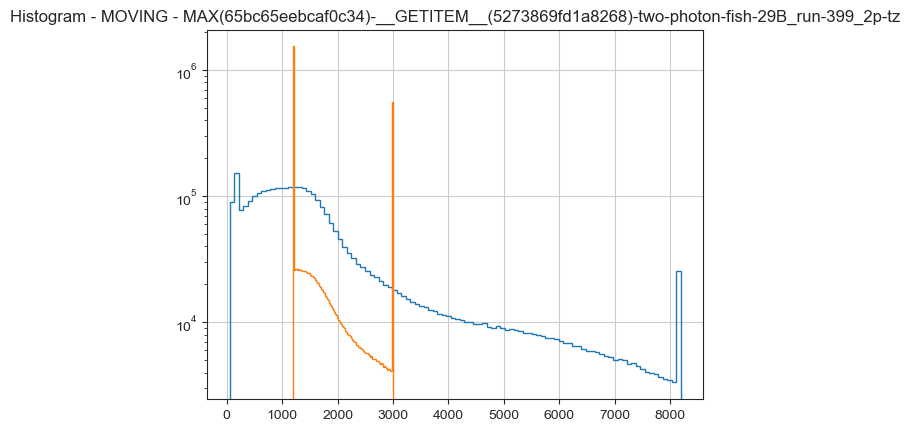

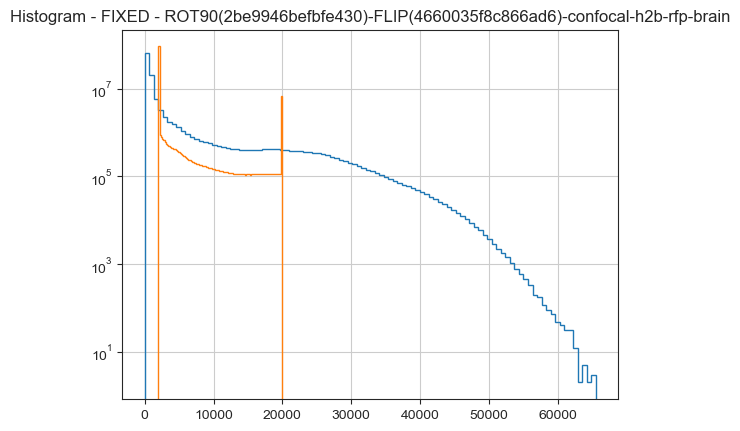

In [19]:
%matplotlib inline

moving_data_1d = moving_im_raw.reshape(-1)
fixed_data_1d = fixed_im_raw.reshape(-1)

# TODO - how should this be done more heurestically?
#        Histogram normalization...
# TODO - look into `use_histogram_matching` parameter in antspy
moving_clip = (1200, 3000)
fixed_clip = (2000, 20000)

moving_im_clip = np.clip(moving_im_raw, *moving_clip)
fixed_im_clip = np.clip(fixed_im_raw, *fixed_clip)

moving_im_clip_1d = moving_im_clip.reshape(-1)
fixed_im_clip_1d = fixed_im_clip.reshape(-1)

plt.hist(moving_data_1d, bins=100, histtype='step')
plt.hist(moving_im_clip_1d, bins=100, histtype='step')
plt.title(f'Histogram - MOVING - {moving_imds.name}')
plt.yscale('log')
plt.grid(True)
plt.show()

plt.hist(fixed_data_1d, bins=100, histtype='step')
plt.hist(fixed_im_clip_1d, bins=100, histtype='step')
plt.title(f'Histogram - FIXED - {fixed_imds.name}')
plt.yscale('log')
plt.grid(True)
plt.show()

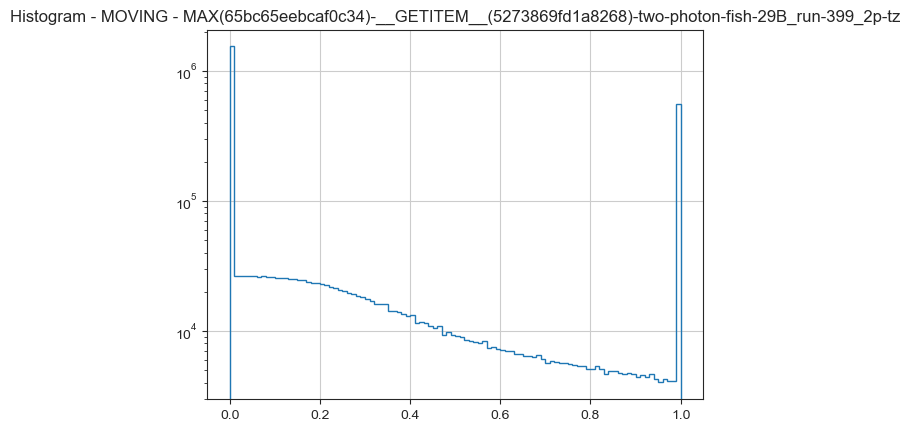

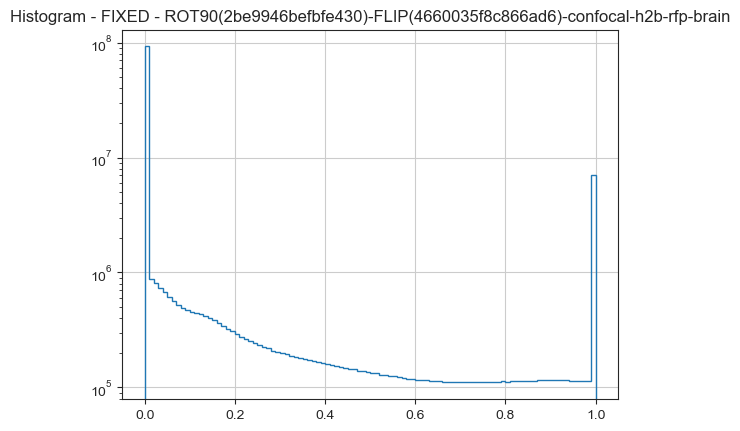

In [20]:
moving_im_float = moving_im_clip.astype(float)
moving_im_float = moving_im_float - moving_im_float.min()
moving_im_float = moving_im_float / moving_im_float.max()

fixed_im_float = fixed_im_clip.astype(float)
fixed_im_float = fixed_im_float - fixed_im_float.min()
fixed_im_float = fixed_im_float / fixed_im_float.max()

plt.hist(moving_im_float.reshape(-1), 
         bins=100, histtype='step')
plt.title(f'Histogram - MOVING - {moving_imds.name}')
plt.yscale('log')
plt.grid(True)
plt.show()

plt.hist(fixed_im_float.reshape(-1), 
         bins=100, histtype='step')
plt.title(f'Histogram - FIXED - {fixed_imds.name}')
plt.yscale('log')
plt.grid(True)
plt.show()

In [21]:
def resize(image: np.ndarray, 
           new_shape: tuple[int, ...] | np.ndarray,
           **kwargs) -> np.ndarray:
    current_shape = np.array(image.shape)
    shape_delta = np.round(new_shape) - current_shape
    if np.all(np.abs(shape_delta) < 0.5):
        return image
    downsize: bool = np.any(shape_delta < 0)
    anti_alias = kwargs.pop('anti_aliasing', downsize)
    return ski.transform.resize(image,
                                output_shape=np.round(new_shape),
                                anti_aliasing=anti_alias,
                                **kwargs)

In [22]:
log.info('Resizing Images')
moving_im_resize = resize(moving_im_float, 
                          new_shape=moving_new_shape)
fixed_im_resize = resize(fixed_im_float, 
                         new_shape=fixed_new_shape)

local-nb_cs-ii-29_import-tests (   1): INFO : Resizing Images


In [86]:
viewer = napari.Viewer()
viewer.add_image(moving_im_resize)
viewer.add_image(fixed_im_resize)
viewer.show()

In [23]:
log.info('Apply Gaussian Filter')

sigma_kernel_um = np.array([2, 1, 1], dtype=float)
sigma_kernel = np.ceil(sigma_kernel_um / min_scale) 

moving_im_filt = ski.filters.gaussian(moving_im_resize, 
                                      sigma=sigma_kernel)
fixed_im_filt = ski.filters.gaussian(fixed_im_float, 
                                     sigma=sigma_kernel)

local-nb_cs-ii-29_import-tests (   1): INFO : Apply Gaussian Filter


In [88]:
viewer = napari.Viewer()
viewer.add_image(moving_im_filt)
viewer.add_image(fixed_im_filt)
viewer.show()

# Performing Registration

In [24]:
@csutils.timed(log)
def register(fixed: np.ndarray, 
             moving: np.ndarray,
             ) -> tuple[np.ndarray, dict]:
    fixed_ants = ants.from_numpy(fixed)
    # TODO - look into setting `spacing` parameter in the conversion
    moving_ants = ants.from_numpy(moving)
    
    # TODO - for a few datasets run a jobs many different compinations of parameters
    #        try type_of_transform=`SyNAggro`
    
    transform = ants.registration(
        fixed=fixed_ants,
        moving=moving_ants,
        type_of_transform='SyN',
        syn_metric='demons',
        # syn_sampling=16,
        verbose=True)
    
    moving_warped = ants.apply_transforms(
        fixed=fixed_ants,
        moving=moving_ants,
        transformlist=transform['fwdtransforms'])
    
    return moving_warped.numpy(), transform
        

In [25]:
log.info('Computing Registration and Performing transform')

moving_im_pre_reg = moving_im_filt
fixed_im_reg = fixed_im_filt

moving_im_reg, reg_transform = register(fixed=fixed_im_reg,
                                        moving=moving_im_pre_reg)

local-nb_cs-ii-29_import-tests (   1): INFO : Computing Registration and Performing transform
antsRegistration -d 3 -r [00000216C26D34D0,00000216C26D3480,1] -m mattes[00000216C26D34D0,00000216C26D3480,1,32,regular,0.2] -t Affine[0.25] -c 2100x1200x1200x0 -s 3x2x1x0 -f 4x2x2x1 -x [NA,NA] -m demons[00000216C26D34D0,00000216C26D3480,1,32] -t SyN[0.200000,3.000000,0.000000] -c [40x20x0,1e-7,8] -s 2x1x0 -f 4x2x1 -u 1 -z 1 -o [C:\Users\CORBAN~1\AppData\Local\Temp\tmp32eh3m06,00000216C26D31A0,00000216C26D3230] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
local-nb_cs-ii-29_import-tests (  36): INFO : register        took 0:07:11.403950 h:m:s.


In [26]:
log.info(f'{reg_transform["fwdtransforms"] = }')
log.info(f'{reg_transform["invtransforms"] = }')
log.info(f'(Fwd == Inv)? : {reg_transform["fwdtransforms"] == reg_transform["invtransforms"]}')
log.info(f'(Fwd[-1] == Inv[0])? : {reg_transform["fwdtransforms"][-1] == reg_transform["invtransforms"][0]}')

local-nb_cs-ii-29_import-tests (   1): INFO : reg_transform["fwdtransforms"] = ['C:\\Users\\CORBAN~1\\AppData\\Local\\Temp\\tmp32eh3m061Warp.nii.gz', 'C:\\Users\\CORBAN~1\\AppData\\Local\\Temp\\tmp32eh3m060GenericAffine.mat']
local-nb_cs-ii-29_import-tests (   2): INFO : reg_transform["invtransforms"] = ['C:\\Users\\CORBAN~1\\AppData\\Local\\Temp\\tmp32eh3m060GenericAffine.mat', 'C:\\Users\\CORBAN~1\\AppData\\Local\\Temp\\tmp32eh3m061InverseWarp.nii.gz']
local-nb_cs-ii-29_import-tests (   3): INFO : (Fwd == Inv)? : False
local-nb_cs-ii-29_import-tests (   4): INFO : (Fwd[-1] == Inv[0])? : True


In [27]:
log.info(f'{fixed_im_reg.shape = }')
log.info(f'{moving_im_pre_reg.shape = }')
log.info(f'{moving_im_reg.shape = }')

# TODO - check habenula locations

local-nb_cs-ii-29_import-tests (   1): INFO : fixed_im_reg.shape = (138, 621, 1406)
local-nb_cs-ii-29_import-tests (   2): INFO : moving_im_pre_reg.shape = (123, 729, 1031)
local-nb_cs-ii-29_import-tests (   3): INFO : moving_im_reg.shape = (138, 621, 1406)


In [93]:
viewer = napari.Viewer()
viewer.add_image(fixed_im_reg,
                 scale=min_scale)
viewer.add_image(moving_im_pre_reg,
                 scale=min_scale)
viewer.add_image(moving_im_reg,
                 scale=min_scale)
viewer.show()

# Import Region Masks

In [28]:
log.info('Loading Mask Database from matfile')
db_ds_info = ref_config.get_dataset_info(name='mask-database')
with h5py.File(db_ds_info.full_path, 'r') as mask_db_matfile:
    log.info(f'{list(mask_db_matfile.keys()) = }') 
    
    sparse_matrix_h5_data = mask_db_matfile['MaskDatabase']
    sparse_data = sparse_matrix_h5_data['data']
    sparse_indices = sparse_matrix_h5_data['ir']
    sparse_ind_pointer = sparse_matrix_h5_data['jc']
    data_shape = np.array(tuple(
        mask_db_matfile[p] for p in ['Zs', 'width', 'height']),
        dtype=int).squeeze()
    data_size = np.cumprod(data_shape)[-1]
    
    mask_names_data = mask_db_matfile['MaskDatabaseNames']
    num_masks = mask_names_data.size
    
    mask_names: list[str] = []
    for data_ref in mask_names_data:
        str_data = mask_db_matfile[data_ref[0]]
        chars = map(chr, (s[0] for s in str_data[:]))
        mask_names.append(''.join(chars))
    sparse_matrix = scipy.sparse.csc_matrix(
        (sparse_data, sparse_indices, sparse_ind_pointer),
        shape=(data_size, num_masks),
        dtype=bool)
    
    masks_ndarray = sparse_matrix.toarray()
    masks_ndarray = masks_ndarray.reshape(
        data_shape.tolist() + [num_masks, ])
    # starting dim order 
    # Z, X, Y, MASK
    # ending dim order
    # MASK, Z, Y, X
    # new position mapping: (-3, -1, -2, 0)    
    masks_ndarray = np.moveaxis(
        masks_ndarray,
        [0, 1, 2, 3],
        [-3, -1, -2, 0])
    # masks_ndarray = np.flip(masks_ndarray, axis=1) # flip about Z axis
    masks_ndarray = np.rot90(masks_ndarray, axes=(2, 3)) # rotate about Z axis 90 deg
    masks_ndarray = np.rot90(masks_ndarray, k=2, axes=(1, 2)) # rotate about X axis 180 deg
    masks_dims = (Dim.CHANNEL,
                  Dim.Z,
                  Dim.Y,
                  Dim.X)
    masks_dim_dict = {d: i for i, d in enumerate(masks_dims)}
    
    log.info('Closing matfile')
    

local-nb_cs-ii-29_import-tests (   1): INFO : Loading Mask Database from matfile
local-nb_cs-ii-29_import-tests (   4): INFO : list(mask_db_matfile.keys()) = ['#refs#', 'DateCreated', 'MaskDatabase', 'MaskDatabaseNames', 'MaskDatabaseOutlines', 'Zs', 'height', 'width']
local-nb_cs-ii-29_import-tests (  49): INFO : Closing matfile


['Diencephalon -',
 'Diencephalon - Anterior group of the posterior tubercular vmat2 neurons',
 'Diencephalon - Anterior preoptic dopaminergic cluster',
 'Diencephalon - Anterior pretectum cluster of vmat2 Neurons',
 'Diencephalon - Caudal Hypothalamus',
 'Diencephalon - Diffuse Nucleus of the Intermediate Hypothalamus',
 'Diencephalon - Dopaminergic Cluster 1 - ventral thalamic and periventricular posterior tubercular DA neurons',
 'Diencephalon - Dopaminergic Cluster 2 - posterior tuberculum',
 'Diencephalon - Dopaminergic Cluster 3 - hypothalamus',
 'Diencephalon - Dopaminergic Cluster 4/5 - posterior tuberculum and hypothalamus',
 'Diencephalon - Dopaminergic Cluster 6 - hypothalamus',
 'Diencephalon - Dopaminergic Cluster 7 - Caudal Hypothalamus',
 'Diencephalon - Dorsal Thalamus',
 'Diencephalon - Eminentia Thalami',
 'Diencephalon - Habenula',
 'Diencephalon - Hypothalamus - Caudal Hypothalamus Neural Cluster',
 'Diencephalon - Hypothalamus - Intermediate Hypothalamus Neural Clu

In [29]:
log.info(f'{masks_ndarray.shape = }')
log.info(f'{ref_ds_prime.shape = }')
log.info(f'{masks_ndarray.dtype = }')

local-nb_cs-ii-29_import-tests (   1): INFO : masks_ndarray.shape = (294, 138, 621, 1406)
local-nb_cs-ii-29_import-tests (   2): INFO : ref_ds_prime.shape = (138, 621, 1406)
local-nb_cs-ii-29_import-tests (   3): INFO : masks_ndarray.dtype = dtype('bool')


In [33]:
log.info('Computing the size of each mask...')
mask_sizes = np.count_nonzero(
    masks_ndarray, 
    axis=(masks_dim_dict[Dim.X],
          masks_dim_dict[Dim.Y],
          masks_dim_dict[Dim.Z]))
mask_sizes_small_first_asort = np.argsort(mask_sizes)
mask_sizes_large_first_asort = np.flip(mask_sizes_small_first_asort)

local-nb_cs-ii-29_import-tests (   1): INFO : Computing the size of each mask...


In [34]:
@csutils.timed(logger=log)
def gen_non_overlapping_labels(mask_data,
                               names,
                               asort=None,
                               ignore_list=None,
                               sizes=None,
                               allowed_overlap_fraction=0.01):
    labels_ndarray = np.zeros(
        shape=mask_data.shape[1:],
        dtype=int)    
    label_names = []
    
    ignore_list = ignore_list or []   
    
    if asort is None:
        asort = range(mask_data)
        
    _count = 0
    for i_mask in asort:
        name = names[i_mask]
        if name in ignore_list:
            continue    
        
        moi = mask_data[i_mask]
        
        if sizes is not None:
            region_size = sizes[i_mask]
        else:
            region_size = np.count_nonzero(moi)    
        allowed_overlap_size = np.round(region_size 
                                        * allowed_overlap_fraction)
        allowed_overlap_size = allowed_overlap_size.astype(int)
        
        overlap_count = np.count_nonzero(labels_ndarray[moi]) 
        use_mask = (overlap_count <= allowed_overlap_size)
        log.debug(f'{i_mask = :3d}, {use_mask = !r:5}, '
                  f'{overlap_count = :8d}, {allowed_overlap_size = :8d}, '
                  f'{name = :s}')
        
        if not use_mask:
            continue
            
        _count += 1
        new_moi = np.logical_and(moi, 
                                 np.logical_not(labels_ndarray))
        labels_ndarray[new_moi] = _count
        label_names.append(name)
    
    return labels_ndarray, label_names



In [118]:
# ALL LABEL MOD

labels_arrays: list[np.ndarray] = []
labels_names_lists: list[list[str]] = []
remaining_labels: set[str] = set(mask_names)
captured_labels: list[str] = []

allowed_overlap = 0.01

i = 0
while remaining_labels:
    log.info('Performing iter {}. Captured {} of {} labels ({} remaining).',
             i, len(captured_labels), len(mask_names), len(remaining_labels))
    
    label_array, label_names = gen_non_overlapping_labels(
        mask_data=masks_ndarray,
        names=mask_names,
        asort=mask_sizes_small_first_asort,
        ignore_list=captured_labels,
        allowed_overlap_fraction=allowed_overlap)
    
    log.info(f'... {len(label_names)                = }')
    log.info(f'... {np.unique(label_array).size - 1 = }')
    
    labels_arrays.append(label_array)
    labels_names_lists.append(label_names)
    captured_labels += label_names
    [remaining_labels.remove(n) for n in label_names]
    
    i += 1

log.info('All labels captured in {} arrays ({} allowed overlap).', 
         len(labels_arrays), allowed_overlap)

local-nb_cs-ii-29_import-tests (  12): INFO : Performing iter 0. Captured 0 of 294 labels (294 remaining).
local-nb_cs-ii-29_import-tests (  36): INFO : i_mask = 184, use_mask = True , overlap_count =        0, allowed_overlap_size =        5, name = Rhombencephalon - Mauthner Cell Axon Cap
local-nb_cs-ii-29_import-tests (  36): INFO : i_mask = 190, use_mask = True , overlap_count =        0, allowed_overlap_size =        5, name = Rhombencephalon - MiR2
local-nb_cs-ii-29_import-tests (  36): INFO : i_mask = 158, use_mask = True , overlap_count =        0, allowed_overlap_size =        6, name = Rhombencephalon - Glyt2 Cluster 10
local-nb_cs-ii-29_import-tests (  36): INFO : i_mask = 160, use_mask = True , overlap_count =        0, allowed_overlap_size =        7, name = Rhombencephalon - Glyt2 Cluster 12
local-nb_cs-ii-29_import-tests (  36): INFO : i_mask = 226, use_mask = True , overlap_count =        0, allowed_overlap_size =        8, name = Rhombencephalon - RoL2
local-nb_cs-ii-2

In [ ]:
mask_ignore_list = [
    'Ganglia - Eyes',
    'Rhombencephalon -',
    'Mesencephalon -',
    'Diencephalon -',
    'Telencephalon -'    
]

small_labels_ndarray, small_label_names = gen_non_overlapping_labels(
    mask_data=masks_ndarray,
    names=mask_names,
    asort=mask_sizes_small_first_asort,
    ignore_list=mask_ignore_list,
    sizes=mask_sizes,
    allowed_overlap_fraction=0.15)
log.info('Found {:d} minimally-intersecting small masks.',
         len(small_label_names))
   
large_labels_ndarray, large_label_names = gen_non_overlapping_labels(
    mask_data=masks_ndarray,
    names=mask_names,
    asort=mask_sizes_large_first_asort,
    ignore_list=mask_ignore_list,
    sizes=mask_sizes,
    allowed_overlap_fraction=0.15) 
log.info('Found {:d} minimally-intersecting large masks.',
         len(large_label_names))

In [32]:
print('large_label_names' + ' = ')
print(large_label_names)
print('small_label_names' + ' = ')
print(small_label_names)

large_label_names = 
['Mesencephalon - Tectum Stratum Periventriculare', 'Rhombencephalon - Rhombomere 7', 'Rhombencephalon - Rhombomere 1', 'Mesencephalon - Tecum Neuropil', 'Diencephalon - Intermediate Hypothalamus', 'Rhombencephalon - Rhombomere 2', 'Spinal Cord', 'Rhombencephalon - Rhombomere 6', 'Mesencephalon - Torus Semicircularis', 'Telencephalon - Pallium', 'Mesencephalon - Tegmentum', 'Rhombencephalon - Rhombomere 3', 'Telencephalon - Subpallium', 'Rhombencephalon - Rhombomere 4', 'Rhombencephalon - Rhombomere 5', 'Diencephalon - Preoptic Area', 'Ganglia - Olfactory Epithelium', 'Diencephalon - Rostral Hypothalamus', 'Telencephalon - Olfactory Bulb', 'Diencephalon - Pretectum', 'Diencephalon - Habenula', 'Diencephalon - Dorsal Thalamus', 'Diencephalon - Ventral Thalamus', 'Ganglia - Facial glossopharyngeal ganglion', 'Telencephalon - Postoptic Commissure', 'Ganglia - Vagal Ganglia', 'Ganglia - Trigeminal Ganglion', 'Telencephalon - Anterior Commisure', 'Diencephalon - Medial 

In [33]:
# large_labels_flip = np.flip(large_labels_ndarray, axis=1)
# small_labels_flip = np.flip(small_labels_ndarray, axis=1)

In [137]:
viewer = napari.Viewer()
viewer.add_labels(large_labels_ndarray, scale=min_scale)
viewer.add_labels(small_labels_ndarray, scale=min_scale)
viewer.add_image(masks_ndarray[0], scale=min_scale)
viewer.add_image(fixed_im_reg, scale=min_scale)
viewer.add_image(moving_im_reg, scale=min_scale)
viewer.show()

## Split Labels Left-Right

In [38]:
points_layer_locs = pd.read_csv(
    os.path.join(repo_dir, 'data', 'points_layer.csv'),
    index_col=0)
points_layer_locs

,axis-0,axis-1,axis-2
index,,,
0.0,11.0,312.085673,471.406416
1.0,11.0,312.085673,595.713066
2.0,32.0,313.754219,1205.566493
3.0,32.0,311.251401,397.156136
4.0,52.0,314.588492,287.032124
5.0,52.0,318.759856,191.090751
6.0,52.0,315.422765,1262.297044
7.0,78.0,313.754219,803.446996
8.0,78.0,317.091310,137.697291


In [39]:
points_layer_locs_arr = points_layer_locs.to_numpy()
centroid = np.mean(points_layer_locs_arr.T, axis=1, keepdims=True)
svd = np.linalg.svd(points_layer_locs_arr.T
                    - centroid)
left = svd[0]
left[:, -1]

array([-0.01519623,  0.99988368,  0.00130423])

In [41]:
meshgrid = np.meshgrid(*(np.arange(sh_i) for sh_i in masks_ndarray.shape[1:]),
                       indexing='ij')
meshmatrix = np.stack([grd.reshape((-1, )) for grd in meshgrid], axis=1)
meshmatrix

array([[   0,    0,    0],
       [   0,    0,    1],
       [   0,    0,    2],
       ...,
       [ 137,  620, 1403],
       [ 137,  620, 1404],
       [ 137,  620, 1405]])

In [124]:
is_brain_left_flat = np.matmul(meshmatrix - centroid.T, left[:, -1]) < 0
is_brain_left_flat

array([ True,  True,  True, ..., False, False, False])

In [125]:
print(f'{np.count_nonzero(is_brain_left_flat) / is_brain_left_flat.size = :.2f}')
is_brain_left = is_brain_left_flat.reshape(masks_ndarray.shape[1:])
print(f'{is_brain_left.shape = }')
print(f'{masks_ndarray.shape = }')

np.count_nonzero(is_brain_left_flat) / is_brain_left_flat.size = 0.51
is_brain_left.shape = (138, 621, 1406)
masks_ndarray.shape = (294, 138, 621, 1406)


In [112]:
viewer = napari.Viewer()
viewer.add_labels(large_labels_ndarray, scale=min_scale)
viewer.add_labels(small_labels_ndarray, scale=min_scale)
viewer.add_image(is_brain_left, scale=min_scale)
viewer.add_image(masks_ndarray[0], scale=min_scale)
viewer.add_image(fixed_im_reg, scale=min_scale)
viewer.add_image(moving_im_reg, scale=min_scale)
viewer.add_points(points_layer_locs_arr, scale=min_scale)
viewer.show()

In [40]:
large_labels_left = large_labels_ndarray * is_brain_left.astype(int)
large_labels_right = large_labels_ndarray * np.logical_not(is_brain_left).astype(int)

large_labels_lr = large_labels_right * 2
_temp = (large_labels_left * 2) - 1
_temp[_temp == -1] = 0
large_labels_lr += _temp

large_label_names_lr = []
for l in large_label_names:
    large_label_names_lr.append(f'LEFT - {l}')
    large_label_names_lr.append(f'RIGHT - {l}')

In [129]:
# ALL LABELS MOD
lr_labels_arrays: list[np.ndarray] = []
lr_labels_names_lists: list[list[str]] = []

# NOTE - there is handedness in one region 'Diencephalon - Right/Left Habenula Vglut2 Cluster' already

for i, (labels_array, labels_names_list) in enumerate(zip(labels_arrays, labels_names_lists)):
    log.info('Splitting left from right for label set {}', i)
    
    log.info(f'... {(np.unique(labels_array).size - 1)       = }')
    
    ref_set = set(np.unique(labels_array).tolist())
    
    large_labels_left = labels_array * is_brain_left.astype(int)
    large_labels_right = labels_array * np.logical_not(is_brain_left).astype(int)
    
    left_set = set(np.unique(large_labels_left).tolist())
    right_set = set(np.unique(large_labels_right).tolist())        
    
    log.info(f'{ref_set.symmetric_difference(left_set)   = }')
    log.info(f'{ref_set.symmetric_difference(right_set)  = }')
    log.info(f'{left_set.symmetric_difference(right_set) = }')
    
    for val in (ref_set.symmetric_difference(left_set)
            .union(ref_set.symmetric_difference(right_set))):
        log.info(f'{val - 1 = } | {labels_names_list[val - 1] = }')
    
    log.info(f'... {len(labels_names_list)                   = }')
    log.info(f'... {(np.unique(large_labels_left).size - 1)  = }')
    log.info(f'... {(np.unique(large_labels_right).size - 1) = }')
    
    _labels_lr = large_labels_right * 2
    _temp = (large_labels_left * 2) - 1
    _temp[_temp == -1] = 0
    _labels_lr += _temp
    
    log.info(f'... {(np.unique(_labels_lr).size - 1)         = }')
    
    _label_names_lr = []
    for l in labels_names_list:
        _label_names_lr.append(f'LEFT - {l}')
        _label_names_lr.append(f'RIGHT - {l}')
        
    log.info(f'... {len(_label_names_lr)                     = }')
        
    lr_labels_arrays.append(_labels_lr)
    lr_labels_names_lists.append(_label_names_lr)

local-nb_cs-ii-29_import-tests (   8): INFO : Splitting left from right for label set 0
local-nb_cs-ii-29_import-tests (  10): INFO : ... (np.unique(labels_array).size - 1)       = 150
local-nb_cs-ii-29_import-tests (  20): INFO : ref_set.symmetric_difference(left_set)   = {136}
local-nb_cs-ii-29_import-tests (  21): INFO : ref_set.symmetric_difference(right_set)  = {132}
local-nb_cs-ii-29_import-tests (  22): INFO : left_set.symmetric_difference(right_set) = {132, 136}
local-nb_cs-ii-29_import-tests (  26): INFO : val - 1 = 135 | labels_names_list[val - 1] = 'Diencephalon - Right Habenula Vglut2 Cluster'
local-nb_cs-ii-29_import-tests (  26): INFO : val - 1 = 131 | labels_names_list[val - 1] = 'Diencephalon - Left Habenula Vglut2 Cluster'
local-nb_cs-ii-29_import-tests (  28): INFO : ... len(labels_names_list)                   = 150
local-nb_cs-ii-29_import-tests (  29): INFO : ... (np.unique(large_labels_left).size - 1)  = 149
local-nb_cs-ii-29_import-tests (  30): INFO : ... (np.un

## Determine The Centroid Location of Each Region 

In [141]:
# ALL LABELS MOD

lr_labels_locs: list[np.ndarray] = []

atlas_shape = np.array(meshgrid[0].shape, dtype=int)

center_ref = [0,
              ((atlas_shape[1] - 1) / 2),
              0]
center_ref = np.array(center_ref)

multi_meshgrid = np.stack(meshgrid, axis=0).astype(float)

for i, (lr_labels_array, labels_names_list) in enumerate(zip(lr_labels_arrays, lr_labels_names_lists)):
    log.info('Getting Region Locations for label set {}', i)
    
    num_labels = len(labels_names_list)
    # log.info(f'... {num_labels                            = }')
    # log.info(f'... {(np.unique(lr_labels_array).size - 1) = }')
    
    loc_arr = np.zeros((num_labels, 3), dtype=float)
    
    for i_label in range(num_labels):
        i_label_one_index = i_label + 1
        moi = lr_labels_array == i_label_one_index
        # nonzero_count = np.count_nonzero(moi)
        # log.info('... labels set label #{}, nonzero = {}',
        #          i_label, nonzero_count)
        if np.logical_not(np.any(moi)):
            loc_arr[i_label, :] = np.NAN
            continue
            
        mesh_locs = multi_meshgrid[:, moi]        
        loc_arr[i_label, :] = (np.mean(mesh_locs, axis=1) - center_ref) / (atlas_shape - 1)
    
    lr_labels_locs.append(loc_arr)
        

local-nb_cs-ii-29_import-tests (  15): INFO : Getting Region Locations for label set 0
local-nb_cs-ii-29_import-tests (  15): INFO : Getting Region Locations for label set 1
local-nb_cs-ii-29_import-tests (  15): INFO : Getting Region Locations for label set 2
local-nb_cs-ii-29_import-tests (  15): INFO : Getting Region Locations for label set 3
local-nb_cs-ii-29_import-tests (  15): INFO : Getting Region Locations for label set 4
local-nb_cs-ii-29_import-tests (  15): INFO : Getting Region Locations for label set 5
local-nb_cs-ii-29_import-tests (  15): INFO : Getting Region Locations for label set 6
local-nb_cs-ii-29_import-tests (  15): INFO : Getting Region Locations for label set 7
local-nb_cs-ii-29_import-tests (  15): INFO : Getting Region Locations for label set 8


# Transformation of Labels to Match Activity Data

In [234]:
log.info(f'{list(reg_transform.keys()) = }')

log.info('Converting label data to ants.')
moving_ants = ants.from_numpy(moving_im_pre_reg)
large_labels_ants = ants.from_numpy(large_labels_lr.astype(float))
log.info(f'{large_labels_lr.shape = }')
log.info(f'{np.unique(large_labels_lr).size = }')

whichtoinvert = []
reversed_fwd = [reg_transform['fwdtransforms'][-1 - i] 
                for i in range(len(reg_transform['fwdtransforms']))]
for itx, ftx  in zip(reg_transform['invtransforms'], 
                     reversed_fwd):
    whichtoinvert.append(itx == ftx)

log.info(f'{whichtoinvert = }')

log.info('Projecting label data into live image space.')
large_labels_live_space_ants = ants.apply_transforms(
    fixed=moving_ants,
    moving=large_labels_ants,
    transformlist=reg_transform['invtransforms'],
    whichtoinvert=whichtoinvert,
    interpolator='genericLabel')

log.info('Resizing data into live image shape.')
large_labels_live_space_ndarray = large_labels_live_space_ants.numpy()
log.info(f'{np.unique(large_labels_live_space_ndarray).size = }')
log.info(f'{moving_new_shape = }')
log.info(f'{live_imds_drop.shape = }')
log.info(f'{large_labels_live_space_ndarray.shape = }')
large_labels_live_space_ndarray = resize(large_labels_live_space_ndarray,
                                         new_shape=live_imds_drop.shape[1:],
                                         anti_aliasing=False,
                                         order=0,
                                         preserve_range=True)
log.info(f'{np.unique(large_labels_live_space_ndarray).size = }')
log.info(f'{large_labels_live_space_ndarray.shape = }')

local-nb_cs-ii-29_import-tests (   1): INFO : list(reg_transform.keys()) = ['warpedmovout', 'warpedfixout', 'fwdtransforms', 'invtransforms']
local-nb_cs-ii-29_import-tests (   3): INFO : Converting label data to ants.
local-nb_cs-ii-29_import-tests (   6): INFO : large_labels_lr.shape = (138, 621, 1406)
local-nb_cs-ii-29_import-tests (   7): INFO : np.unique(large_labels_lr).size = 5
local-nb_cs-ii-29_import-tests (  16): INFO : whichtoinvert = [True, False]
local-nb_cs-ii-29_import-tests (  18): INFO : Projecting label data into live image space.
local-nb_cs-ii-29_import-tests (  26): INFO : Resizing data into live image shape.
local-nb_cs-ii-29_import-tests (  28): INFO : np.unique(large_labels_live_space_ndarray).size = 5
local-nb_cs-ii-29_import-tests (  29): INFO : moving_new_shape = array([ 123.,  729., 1031.])
local-nb_cs-ii-29_import-tests (  30): INFO : live_imds_drop.shape = (1710, 18, 362, 512)
local-nb_cs-ii-29_import-tests (  31): INFO : large_labels_live_space_ndarray.sh

In [131]:
# ALL LABEL MOD

log.info(f'{list(reg_transform.keys()) = }')

log.info('Converting label data to ants.')

labels_arrays_live_space: list[np.ndarray] = []

for i, labels_array in enumerate(lr_labels_arrays): 
    log.info('>>> Transforming label data for set {} <<<', i)
    
    moving_ants = ants.from_numpy(moving_im_pre_reg)
    labels_ants = ants.from_numpy(labels_array.astype(float))
    log.info(f'{labels_array.shape = }')
    log.info(f'{np.unique(labels_array).size = }')
    
    whichtoinvert = []
    reversed_fwd = [reg_transform['fwdtransforms'][-1 - i] 
                    for i in range(len(reg_transform['fwdtransforms']))]
    for itx, ftx  in zip(reg_transform['invtransforms'], 
                         reversed_fwd):
        whichtoinvert.append(itx == ftx)
    
    log.info(f'{whichtoinvert = }')
    
    log.info('Projecting label data into live image space.')
    labels_live_space_ants = ants.apply_transforms(
        fixed=moving_ants,
        moving=labels_ants,
        transformlist=reg_transform['invtransforms'],
        whichtoinvert=whichtoinvert,
        interpolator='genericLabel')
    
    log.info('Resizing data into live image shape.')
    labels_live_space_ndarray = labels_live_space_ants.numpy()
    log.info(f'{np.unique(labels_live_space_ndarray).size = }')
    log.info(f'{moving_new_shape = }')
    log.info(f'{live_imds_drop.shape = }')
    log.info(f'{labels_live_space_ndarray.shape = }')
    labels_live_space_ndarray = resize(labels_live_space_ndarray,
                                       new_shape=live_imds_drop.shape[1:],
                                       anti_aliasing=False,
                                       order=0,
                                       preserve_range=True)
    log.info(f'{np.unique(labels_live_space_ndarray).size = }')
    log.info(f'{labels_live_space_ndarray.shape = }')
    
    labels_arrays_live_space.append(labels_live_space_ndarray)

local-nb_cs-ii-29_import-tests (   3): INFO : list(reg_transform.keys()) = ['warpedmovout', 'warpedfixout', 'fwdtransforms', 'invtransforms']
local-nb_cs-ii-29_import-tests (   5): INFO : Converting label data to ants.
local-nb_cs-ii-29_import-tests (  10): INFO : >>> Transforming label data for set 0 <<<
local-nb_cs-ii-29_import-tests (  14): INFO : labels_array.shape = (138, 621, 1406)
local-nb_cs-ii-29_import-tests (  15): INFO : np.unique(labels_array).size = 299
local-nb_cs-ii-29_import-tests (  24): INFO : whichtoinvert = [True, False]
local-nb_cs-ii-29_import-tests (  26): INFO : Projecting label data into live image space.
local-nb_cs-ii-29_import-tests (  34): INFO : Resizing data into live image shape.
local-nb_cs-ii-29_import-tests (  36): INFO : np.unique(labels_live_space_ndarray).size = 279
local-nb_cs-ii-29_import-tests (  37): INFO : moving_new_shape = array([ 123.,  729., 1031.])
local-nb_cs-ii-29_import-tests (  38): INFO : live_imds_drop.shape = (1710, 18, 362, 512)


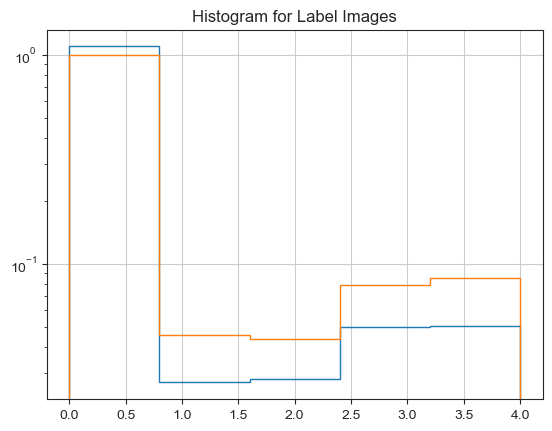

In [235]:
%matplotlib inline
large_labels_live_space_ndarray = large_labels_live_space_ndarray.astype(int)
plt.hist(large_labels_lr.reshape(-1), 
         bins=len(large_label_names_lr) + 1, 
         histtype='step',
         density=True)
plt.hist(large_labels_live_space_ndarray.reshape(-1), 
         bins=len(large_label_names_lr) + 1, 
         histtype='step',
         density=True)
plt.title(f'Histogram for Label Images')
plt.yscale('log')
plt.grid(True)
plt.show()

In [280]:
viewer = napari.Viewer()
viewer.add_labels(large_labels_live_space_ndarray,
                  scale=live_max_proj_ds.scale)
viewer.add_image(live_max_proj_ds.get_image_data(),
                 scale=live_max_proj_ds.scale)
live_imds_drop.add_to_napari(viewer)
live_imds_drop.apply_standard_napari_config(viewer)
viewer.show()

# Extract Activity

In [236]:
log.info('Determining Remaining Labels')

labels_ndarray = large_labels_live_space_ndarray
label_names_raw = large_label_names_lr

label_names = []
num_labels = len(label_names_raw)
is_label_present = np.zeros((len(large_label_names_lr), ),
                            dtype=bool)

VOXEL_COUNT_MINIMUM = 800/2

for i_label in range(num_labels):
    label_voxel_count = np.count_nonzero(labels_ndarray == (i_label + 1))
    is_label_present[i_label] = label_voxel_count > VOXEL_COUNT_MINIMUM
    label_names.append(f'#{i_label + 1:03d} | '
                       f'{label_voxel_count / 1E3:.2f}k vxl | '
                       f'{label_names_raw[i_label]}')
    
    
num_labels_present = np.count_nonzero(is_label_present)
arg_labels_present = np.nonzero(is_label_present)[0]
log.info('{:d} labels present out of {:d} total in set.',
         num_labels_present,
         num_labels)

local-nb_cs-ii-29_import-tests (   1): INFO : Determining Remaining Labels
local-nb_cs-ii-29_import-tests (  23): INFO : 4 labels present out of 4 total in set.


## Compute Sizes of Each Region

In [132]:
# ALL LABELS MOD

# extract the size of each region

labels_arrays_sizes: list[np.ndarray] = []

for i, (labels_array, label_names_list) in enumerate(zip(labels_arrays_live_space, lr_labels_names_lists)):    
    unique_vals = np.unique(labels_array)
    print(f'{(unique_vals.size - 1) = }')
    print(f'{len(label_names_list) = }')
    count_arr = np.zeros((len(label_names_list), ))
    for j in range(count_arr.size):     
        count_arr[j] = np.count_nonzero(labels_array == (j + 1))
    
    labels_arrays_sizes.append(count_arr)
    log.info('Counts for labels set {}: {}', i, count_arr)

(unique_vals.size - 1) = 273
len(label_names_list) = 300
local-nb_cs-ii-29_import-tests (  16): INFO : Counts for labels set 0: [4.00000e+00 1.40000e+01 1.00000e+01 5.00000e+00 2.00000e+00 4.90000e+01
 5.40000e+01 3.60000e+01 1.70000e+01 6.20000e+01 4.10000e+01 1.60000e+01
 1.40000e+01 3.30000e+01 7.00000e+00 5.10000e+01 1.50000e+01 2.00000e+00
 1.09000e+02 8.50000e+01 1.70000e+01 2.50000e+01 7.90000e+01 2.90000e+01
 3.70000e+01 4.00000e+01 7.40000e+01 3.30000e+01 3.90000e+01 3.10000e+01
 3.00000e+01 2.10000e+01 3.30000e+01 4.90000e+01 5.00000e+01 4.70000e+01
 3.20000e+01 3.40000e+01 1.84000e+02 5.60000e+01 3.30000e+01 4.70000e+01
 9.30000e+01 6.50000e+01 4.90000e+01 2.10000e+01 6.20000e+01 2.20000e+01
 1.27000e+02 2.70000e+01 6.40000e+01 4.00000e+01 7.40000e+01 4.50000e+01
 6.80000e+01 6.30000e+01 8.10000e+01 1.26000e+02 9.40000e+01 9.60000e+01
 7.90000e+01 7.70000e+01 0.00000e+00 0.00000e+00 9.80000e+01 9.80000e+01
 4.80000e+01 9.40000e+01 8.20000e+01 5.70000e+01 1.54000e+02 6.40000e

In [151]:
# ALL MASK MOD

# Get total Counts
all_mask_merge = np.zeros(labels_arrays_live_space[0].shape, dtype=bool)

for i, labels_array in enumerate(labels_arrays_live_space):
    log.info('Performing merge of label set {} to create and all region mask.',
             i)
    all_mask_merge = np.logical_or(all_mask_merge, labels_array > 0)
    
total_voxel_count = np.count_nonzero(all_mask_merge)
log.info(f'{total_voxel_count = }')
log.info(f'{total_voxel_count / all_mask_merge.size = }')

local-nb_cs-ii-29_import-tests (   5): INFO : Performing merge of label set 0 to create and all region mask.
local-nb_cs-ii-29_import-tests (   5): INFO : Performing merge of label set 1 to create and all region mask.
local-nb_cs-ii-29_import-tests (   5): INFO : Performing merge of label set 2 to create and all region mask.
local-nb_cs-ii-29_import-tests (   5): INFO : Performing merge of label set 3 to create and all region mask.
local-nb_cs-ii-29_import-tests (   5): INFO : Performing merge of label set 4 to create and all region mask.
local-nb_cs-ii-29_import-tests (   5): INFO : Performing merge of label set 5 to create and all region mask.
local-nb_cs-ii-29_import-tests (   5): INFO : Performing merge of label set 6 to create and all region mask.
local-nb_cs-ii-29_import-tests (   5): INFO : Performing merge of label set 7 to create and all region mask.
local-nb_cs-ii-29_import-tests (   5): INFO : Performing merge of label set 8 to create and all region mask.
local-nb_cs-ii-29_i

In [237]:
log.info('Extrtacting Aggregate Traces:')
bit_depth = live_imds.source_data.metadata[pvi.pvmk.BIT_DEPTH]
log.info('Bit-depth for live data is: {}', bit_depth)
BIT_MAX = float((2 ** bit_depth) - 1)

live_image_data = live_imds_drop.get_image_data()

output_traces = np.zeros((num_labels_present, live_imds_drop.shape_dict[Dim.TIME]),
                         dtype=float)

for i, i_label in enumerate(arg_labels_present):
    log.info('Processing Region "{}"',
             label_names[i_label])
    moi = labels_ndarray == (i_label + 1)
    log.debug(f'{np.count_nonzero(moi) = }')
    selected_data = live_image_data[:, moi]
    log.debug(f'{selected_data.shape = }')
    selected_data = np.mean(selected_data, axis=1)
    selected_data = selected_data / BIT_MAX
    log.debug(f'{selected_data.shape = }')
    output_traces[i, :] = selected_data

local-nb_cs-ii-29_import-tests (   1): INFO : Extrtacting Aggregate Traces:
local-nb_cs-ii-29_import-tests (   3): INFO : Bit-depth for live data is: 13
local-nb_cs-ii-29_import-tests (  12): INFO : Processing Region "#001 | 121.73k vxl | LEFT - Diencephalon -"
local-nb_cs-ii-29_import-tests (  12): INFO : Processing Region "#002 | 116.20k vxl | RIGHT - Diencephalon -"
local-nb_cs-ii-29_import-tests (  12): INFO : Processing Region "#003 | 211.70k vxl | LEFT - Rhombencephalon -"
local-nb_cs-ii-29_import-tests (  12): INFO : Processing Region "#004 | 227.52k vxl | RIGHT - Rhombencephalon -"


In [133]:
# ALL LABELS MOD
log.info('Extrtacting Aggregate Traces:')
bit_depth = live_imds.source_data.metadata[pvi.pvmk.BIT_DEPTH]
log.info('Bit-depth for live data is: {}', bit_depth)
BIT_MAX = float((2 ** bit_depth) - 1)

live_image_data = live_imds_drop.get_image_data()

total_num_regions = np.sum([lsz.size for lsz in labels_arrays_sizes])

log.info(f'{total_num_regions = }')

output_traces = np.zeros((7, total_num_regions, live_imds_drop.shape_dict[Dim.TIME]),
                         dtype=float)

local-nb_cs-ii-29_import-tests (   2): INFO : Extrtacting Aggregate Traces:
local-nb_cs-ii-29_import-tests (   4): INFO : Bit-depth for live data is: 13
local-nb_cs-ii-29_import-tests (  11): INFO : total_num_regions = 588


In [238]:
log.info(f'{output_traces.shape = }')

local-nb_cs-ii-29_import-tests (   1): INFO : output_traces.shape = (4, 1710)


In [135]:
# ALL LABELS MOD

master_index = -1

for i_label_set, (labels_array, labels_sizes, labels_names_list) in \
        enumerate(zip(labels_arrays_live_space, labels_arrays_sizes, lr_labels_names_lists)):


    for label_index, label_size in enumerate(labels_sizes): 
        master_index += 1
        label_one_index = label_index + 1
        
        log.info('Processing Region {:03d} - "{}"',
                 master_index,
                 labels_names_list[label_index])
        
        if label_size == 0:
            log.info('...region is empty.')
            output_traces[:, master_index, :] = np.NAN
            continue
            
        moi = labels_array == label_one_index
 
        selected_data = live_image_data[:, moi]
        selected_data = selected_data / BIT_MAX
        
        selected_data_qtiles = np.quantile(
            selected_data, 
            [0.95, 0.75, 0.5, 0.25, 0.05], 
            axis=1)        
        selected_data_mean = np.mean(selected_data, axis=1)        
        selected_data_var = np.var(selected_data, axis=1)  
        
        log.debug(f'...{selected_data_qtiles.shape = }')
        log.debug(f'...{selected_data_mean.shape = }')
        log.debug(f'...{selected_data_var.shape = }')
        
        output_traces[0:5, master_index, :] = selected_data_qtiles
        output_traces[5, master_index, :] = selected_data_mean
        output_traces[6, master_index, :] = selected_data_var
        
        
        

local-nb_cs-ii-29_import-tests (  13): INFO : Processing Region 000 - "LEFT - Rhombencephalon - Mauthner Cell Axon Cap"
local-nb_cs-ii-29_import-tests (  13): INFO : Processing Region 001 - "RIGHT - Rhombencephalon - Mauthner Cell Axon Cap"
local-nb_cs-ii-29_import-tests (  13): INFO : Processing Region 002 - "LEFT - Rhombencephalon - MiR2"
local-nb_cs-ii-29_import-tests (  13): INFO : Processing Region 003 - "RIGHT - Rhombencephalon - MiR2"
local-nb_cs-ii-29_import-tests (  13): INFO : Processing Region 004 - "LEFT - Rhombencephalon - Glyt2 Cluster 10"
local-nb_cs-ii-29_import-tests (  13): INFO : Processing Region 005 - "RIGHT - Rhombencephalon - Glyt2 Cluster 10"
local-nb_cs-ii-29_import-tests (  13): INFO : Processing Region 006 - "LEFT - Rhombencephalon - Glyt2 Cluster 12"
local-nb_cs-ii-29_import-tests (  13): INFO : Processing Region 007 - "RIGHT - Rhombencephalon - Glyt2 Cluster 12"
local-nb_cs-ii-29_import-tests (  13): INFO : Processing Region 008 - "LEFT - Rhombencephalon - 

In [143]:
# ALL LABELS MOD

# correcting labels to create multiindex

# (region, sub region, side, value type)
multiindex_names = ['region', 'sub_region', 'lateral_side', 'value_type']

value_type_list = [
    'quantile_95', 
    'quantile_75',
    'quantile_50',
    'quantile_25',
    'quantile_05',
    'mean',
    'variance']

all_label_names: list[str] = list(it.chain(*lr_labels_names_lists))

all_label_tuples: list[tuple] = []

for i, label_name in enumerate(all_label_names):
    split_result = label_name.split('-')
    side_str = split_result[0].strip().lower()
    region_str = split_result[1].strip()
    subregion_str = ('-'.join(split_result[2:])).strip()
    
    subregion_str = subregion_str or region_str
    
    label_tup = (region_str, subregion_str, side_str)
    all_label_tuples.append(label_tup)
    
    log.info('Region {:03d} - {}', i, label_tup)

local-nb_cs-ii-29_import-tests (  32): INFO : Region 000 - ('Rhombencephalon', 'Mauthner Cell Axon Cap', 'left')
local-nb_cs-ii-29_import-tests (  32): INFO : Region 001 - ('Rhombencephalon', 'Mauthner Cell Axon Cap', 'right')
local-nb_cs-ii-29_import-tests (  32): INFO : Region 002 - ('Rhombencephalon', 'MiR2', 'left')
local-nb_cs-ii-29_import-tests (  32): INFO : Region 003 - ('Rhombencephalon', 'MiR2', 'right')
local-nb_cs-ii-29_import-tests (  32): INFO : Region 004 - ('Rhombencephalon', 'Glyt2 Cluster 10', 'left')
local-nb_cs-ii-29_import-tests (  32): INFO : Region 005 - ('Rhombencephalon', 'Glyt2 Cluster 10', 'right')
local-nb_cs-ii-29_import-tests (  32): INFO : Region 006 - ('Rhombencephalon', 'Glyt2 Cluster 12', 'left')
local-nb_cs-ii-29_import-tests (  32): INFO : Region 007 - ('Rhombencephalon', 'Glyt2 Cluster 12', 'right')
local-nb_cs-ii-29_import-tests (  32): INFO : Region 008 - ('Rhombencephalon', 'RoL2', 'left')
local-nb_cs-ii-29_import-tests (  32): INFO : Region 009 

In [239]:
%matplotlib qt

if live_imds.source_data.metadata['bidirectionalZ']:
    log.info('Downscaling data due to bidirectional scan.')
    original_size = output_traces.shape[1]
    new_size = original_size - (0 if (original_size % 2) == 0 else 1)
    output_traces_downscale = ski.transform.downscale_local_mean(
        output_traces[:, :new_size],
        factors=(1, 2))
    new_time_vector = ski.transform.downscale_local_mean(
        live_imds_drop.coordinates[Dim.TIME].vector[:new_size],
        factors=(2, ))
else:
    output_traces_downscale = output_traces
    new_time_vector = live_imds_drop.coordinates[Dim.TIME].vector
    

In [240]:
log.info('Plotting all raw traces')
ax = plt.subplot(1, 1, 1)
line_plots = ax.plot(new_time_vector,
                     output_traces_downscale.T)
ax.legend(line_plots,
          tuple(label_names[i] for i in arg_labels_present),
          loc='center left',
          bbox_to_anchor=(1, 0.5))
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
plt.show()

local-nb_cs-ii-29_import-tests (   1): INFO : Plotting all raw traces


In [241]:
log.info('Taking moving baseline')

smooth_sigma_sec = 1.0
smooth_sigma_truncate = 2.5

smooth_sigma = np.count_nonzero(new_time_vector < smooth_sigma_sec)

if smooth_sigma > 0:
    output_traces_smooth = scipy.ndimage.gaussian_filter1d(
        output_traces_downscale,
        sigma=smooth_sigma,
        axis=1,
        mode='nearest',
        truncate=smooth_sigma_truncate)
else:
    output_traces_smooth = output_traces_downscale

moving_quantile_size_sec = 60 * 4
moving_quantile_size = np.count_nonzero(new_time_vector < moving_quantile_size_sec)
output_traces_df = pd.DataFrame(output_traces_smooth)
output_traces_baseline = \
    output_traces_df\
    .rolling(window=moving_quantile_size,
             min_periods=1,
             center=False,
             axis=1,
             closed='both')\
    .quantile(0.05)
  
output_traces_baseline = output_traces_baseline.to_numpy()
log.info(f'{output_traces_baseline.shape = }')
output_traces_baseline_diff = np.diff(output_traces_baseline,
                                      n=1,
                                      axis=1)
log.info(f'{output_traces_baseline_diff.shape = }')
log.info(f'{output_traces_baseline_diff.min() = }, {output_traces_baseline_diff.max() = }')
max_change_rate = 30E-6
max_change_rate_norm = max_change_rate * live_imds_drop.coordinates[Dim.TIME].median_pitch
new_diff = np.clip(output_traces_baseline_diff,
                   a_min=(-1 * max_change_rate_norm),
                   a_max=max_change_rate_norm)
log.info(f'{new_diff.shape = }')
log.info(f'{new_diff.min() = }, {new_diff.max() = }')
zero_append = np.zeros(
    shape=(output_traces_baseline.shape[0], 1),
    dtype=output_traces_baseline.dtype)
log.info(f'{zero_append.shape = }')
rate_lim_baseline = np.cumsum(
    np.concatenate((zero_append, new_diff), 
                   axis=1),
    axis=1)
log.info(f'{rate_lim_baseline.shape = }')

arg_min_baseline = np.argmin(output_traces_baseline,
                             axis=1,
                             keepdims=True)
log.info(f'{arg_min_baseline.shape = }')
min_baseline = np.take_along_axis(output_traces_baseline,
                                  arg_min_baseline,
                                  axis=1)
log.info(f'{min_baseline.shape = }')
rate_lim_baseline = (
        rate_lim_baseline 
        - np.take_along_axis(rate_lim_baseline,
                             arg_min_baseline,
                             axis=1)                             
        + min_baseline)
log.info(f'{rate_lim_baseline.shape = }')

output_traces_baseline_original = output_traces_baseline
output_traces_baseline = rate_lim_baseline
log.info(f'{output_traces_baseline.shape = }')
                            
# output_traces_baseline = scipy.ndimage.minimum_filter(
#     output_traces_smooth,
#     size=(1, moving_quantile_size),
#     mode='nearest')

# output_traces_clip = np.zeros(output_traces_smooth.shape)
clip_mask = output_traces_smooth < output_traces_baseline
output_traces_clip = output_traces_smooth.copy()
output_traces_clip[clip_mask] = output_traces_baseline[clip_mask]
traces_delta = output_traces_clip - output_traces_baseline
traces_df_over_f = traces_delta / output_traces_baseline
traces_df_over_f = traces_df_over_f[:, :]
traces_labels = [label_names[a] for a in arg_labels_present]
new_time_vector_mask = new_time_vector[:]
traces_mask = np.all(output_traces_downscale > 0.008,
                     axis=-1)
traces_df_over_f_mask = traces_df_over_f[traces_mask, :]
traces_labels_mask = [l for l, include in zip(traces_labels, traces_mask) if include]

print('traces_labels = ')
_ = [print(f'\t{i:3d} : {t}') for i, t in enumerate(traces_labels)]

print('traces_labels_mask = ')
_ = [print(f'\t{i:3d} : {t}') for i, t in enumerate(traces_labels)]

local-nb_cs-ii-29_import-tests (   1): INFO : Taking moving baseline
local-nb_cs-ii-29_import-tests (  31): INFO : output_traces_baseline.shape = (4, 1710)
local-nb_cs-ii-29_import-tests (  35): INFO : output_traces_baseline_diff.shape = (4, 1709)
local-nb_cs-ii-29_import-tests (  36): INFO : output_traces_baseline_diff.min() = -0.0003180999662419498, output_traces_baseline_diff.max() = 0.0001192092787840604
local-nb_cs-ii-29_import-tests (  42): INFO : new_diff.shape = (4, 1709)
local-nb_cs-ii-29_import-tests (  43): INFO : new_diff.min() = -1.4913111000000328e-05, new_diff.max() = 1.4913111000000328e-05
local-nb_cs-ii-29_import-tests (  47): INFO : zero_append.shape = (4, 1)
local-nb_cs-ii-29_import-tests (  52): INFO : rate_lim_baseline.shape = (4, 1710)
local-nb_cs-ii-29_import-tests (  57): INFO : arg_min_baseline.shape = (4, 1)
local-nb_cs-ii-29_import-tests (  61): INFO : min_baseline.shape = (4, 1)
local-nb_cs-ii-29_import-tests (  68): INFO : rate_lim_baseline.shape = (4, 1710

In [242]:
# ALL LABELS MOD
new_time_vector_mask = new_time_vector

In [253]:
for i in [2, ]:
    plt.figure()
    ax1 = plt.subplot(2, 1, 1)
    ax1.plot(live_imds_drop.coordinates[Dim.TIME].vector,
             output_traces[i, :],
             'r',
             label=f'f_{i+1}',
             lw=3,
             alpha=0.4)    
    ax1.plot(new_time_vector,
             output_traces_smooth[i],
             'r',
             label=f'f_{{{i+1},smooth}}',
             lw=2,
             alpha=0.85)
    ax1.plot(new_time_vector,
             output_traces_baseline_original[i],
             'k',
             lw=3,
             alpha=0.4,
             label=f'f_{{{i+1},rolling-qt}}')
    ax1.plot(new_time_vector,
             output_traces_baseline[i],
             'k',
             lw=2,
             alpha=0.85,
             label=f'f_{{{i+1},drift-limited}}')

    # ax1.plot(new_time_vector,
    #          output_traces_downscale[i],
    #          label='RAW-DOWNSCALE',
    #          alpha=0.5)

    ax1.plot(new_time_vector,
             output_traces_clip[i],
             'g',
             label=f'f_{{{i+1},smooth-clip}}',
             lw=2,
             alpha=0.85)

    plt.title(traces_labels[i])
    ax2 = plt.subplot(2, 1, 2, sharex=ax1)
    ax2.plot(new_time_vector_mask,
             traces_df_over_f[i],
             label=f'f_{{{i+1},norm}}',
             lw=2.5)    
    ax2.axhline(0,
                lw=0.5,
                c='k',
                zorder=1)
    ax1.legend()
    ax2.legend()
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Mean Relative Voxel Intensity (a.u.)')
    
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Normalized Intensity (a.u.)')
    plt.show()

In [182]:
%matplotlib qt
log.info('Plotting all delta f over f traces')
ax = plt.subplot(1, 1, 1)
line_plots = ax.plot(new_time_vector_mask,
                     traces_df_over_f_mask.T)
ax.legend(line_plots,
          traces_labels_mask,
          loc='center left',
          bbox_to_anchor=(1, 0.5))
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
plt.show()

local-nb_cs-ii-29_import-tests (   2): INFO : Plotting all delta f over f traces


C:\Users\CorbanSwain\AppData\Local\Temp\ipykernel_49676\430271188.py:3: MatplotlibDeprecationWarning:

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.



In [183]:
%matplotlib qt
ax = plt.subplot(1, 1, 1)
spacing = 1 * (traces_df_over_f_mask.max() - traces_df_over_f_mask.min()) * 1
scaling = 4
ones_arr = np.ones(new_time_vector_mask.shape)
for i, (trace, label) in enumerate(zip(traces_df_over_f_mask, traces_labels_mask)):
    zero_loc = (i * spacing)
    ax.plot(new_time_vector_mask,
            (trace * scaling) + zero_loc, 
            'r',
            label=label,
            zorder=(num_labels_present - i) + 10,
            lw=2)
    ax.fill_between(
        new_time_vector_mask,
        ones_arr * zero_loc,
        (trace * scaling) + zero_loc,
        interpolate=False,
        fc='w',
        zorder=(num_labels_present - i) + 10)
    ax.axhline(zero_loc,
               lw=0.5,
               c='k',
               zorder=1)
    
ax.legend(loc='center left',
          bbox_to_anchor=(1, 0.5))
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
plt.show()

## Generate Time Reference

In [192]:
import datetime as dt

live_pv_md = live_imds.source_data.metadata

live_datetime_start = pvi._parse_time_str(live_pv_md[pvi.pvmk.TIMESTAMP])
print(f'{live_datetime_start = !r}')

precise_time_start_raw = pvi._parse_time_str(live_pv_md[pvi.pvmk.TIME][0])
print(f'{precise_time_start_raw = !r}')

precise_time_scan_start = dt.datetime(
    year=live_datetime_start.year,
    month=live_datetime_start.month,
    day=live_datetime_start.day,
    hour=precise_time_start_raw.hour,
    minute=precise_time_start_raw.minute,
    second=precise_time_start_raw.second,
    microsecond=precise_time_start_raw.microsecond)

print(f'{precise_time_scan_start = !r}')

extra_time_delta = live_pv_md['absoluteTime'][0][0]
extra_time_delta = dt.timedelta(seconds=extra_time_delta)
print(f'{extra_time_delta = }')

precise_time_trigger_start = precise_time_scan_start + extra_time_delta
precise_time_trigger_start_64 = pd.to_datetime(precise_time_trigger_start)
print(f'{precise_time_trigger_start_64 = }')

conv_time_vector = [
    precise_time_trigger_start_64
    + pd.to_timedelta(v, unit='s')
    for v in new_time_vector_mask]
        
time_index = pd.DatetimeIndex(conv_time_vector)

live_datetime_start = datetime.datetime(2023, 8, 3, 17, 41, 28)
precise_time_start_raw = datetime.datetime(1, 1, 1, 17, 41, 28, 535532)
precise_time_scan_start = datetime.datetime(2023, 8, 3, 17, 41, 28, 535532)
extra_time_delta = datetime.timedelta(seconds=23, microseconds=42000)
precise_time_trigger_start_64 = Timestamp('2023-08-03 17:41:51.577532')


## Create Activity Enhanced Volume

In [70]:
region_traces = output_traces_clip
region_int_labels = arg_labels_present[1:]

# rescale each region
region_traces -= np.min(region_traces, axis=0, keepdims=True)
region_traces /= np.max(region_traces, axis=0, keepdims=True)

output_labels = labels_ndarray
mod_volume = np.zeros(live_imds_drop.shape)

In [71]:
for i, region_int in enumerate(region_int_labels):
    print(f'BEGINNING CYCLE {i+1:02d} / {region_int_labels.size:02d}, '
          f'Region {region_int}')
    print(f'{region_int = }')
    label_select = output_labels == region_int
    print(f'{np.count_nonzero(label_select) = }')
    assignment = region_traces[i].reshape((-1, 1))
    # select = mod_volume[:, label_select]
    # print(f'{select.shape = }')
    mod_volume[:, label_select] = assignment
    print(f'made assignment')

BEGINNING CYCLE 01 / 76, Region 1
region_int = 1
np.count_nonzero(label_select) = 68637
made assignment
BEGINNING CYCLE 02 / 76, Region 2
region_int = 2
np.count_nonzero(label_select) = 72386
made assignment
BEGINNING CYCLE 03 / 76, Region 3
region_int = 3
np.count_nonzero(label_select) = 45127
made assignment
BEGINNING CYCLE 04 / 76, Region 4
region_int = 4
np.count_nonzero(label_select) = 50979
made assignment
BEGINNING CYCLE 05 / 76, Region 5
region_int = 5
np.count_nonzero(label_select) = 55149
made assignment
BEGINNING CYCLE 06 / 76, Region 6
region_int = 6
np.count_nonzero(label_select) = 55361
made assignment
BEGINNING CYCLE 07 / 76, Region 7
region_int = 7
np.count_nonzero(label_select) = 34354
made assignment
BEGINNING CYCLE 08 / 76, Region 8
region_int = 8
np.count_nonzero(label_select) = 38246
made assignment
BEGINNING CYCLE 09 / 76, Region 9
region_int = 9
np.count_nonzero(label_select) = 32524
made assignment
BEGINNING CYCLE 10 / 76, Region 10
region_int = 10
np.count_nonz

In [73]:
print('Performing multiplication...')
output_volume = live_max_proj_ds.get_image_data().astype(np.float32) * mod_volume.astype(np.float32)

print(f'{mod_volume.shape = }')
print(f'{live_imds_drop.shape = }')
print(f'{output_volume.shape = }')

Performing multiplication...
mod_volume.shape = (1710, 18, 362, 512)
live_imds_drop.shape = (1710, 18, 362, 512)
output_volume.shape = (1710, 18, 362, 512)


In [110]:
viewer = napari.Viewer()
viewer.add_labels(large_labels_live_space_ndarray,
                  scale=live_max_proj_ds.scale)
viewer.add_image(mod_volume,
                 scale=(1, ) + live_max_proj_ds.scale)
viewer.add_image(output_volume,
                 scale=(1, ) + live_max_proj_ds.scale)
viewer.show()

## Create Functional Activity DataFrame

In [83]:
functional_activity_df = pd.DataFrame(
    traces_df_over_f_mask.T,    
    columns=traces_labels_mask,
    index=time_index
)
functional_activity_df

,#001 | 68.64k vxl | LEFT - Mesencephalon - Tectum Stratum Periventriculare,#002 | 72.39k vxl | RIGHT - Mesencephalon - Tectum Stratum Periventriculare,#003 | 45.13k vxl | LEFT - Rhombencephalon - Rhombomere 7,#004 | 50.98k vxl | RIGHT - Rhombencephalon - Rhombomere 7,#005 | 55.15k vxl | LEFT - Rhombencephalon - Rhombomere 1,#006 | 55.36k vxl | RIGHT - Rhombencephalon - Rhombomere 1,#007 | 34.35k vxl | LEFT - Mesencephalon - Tecum Neuropil,#008 | 38.25k vxl | RIGHT - Mesencephalon - Tecum Neuropil,#009 | 32.52k vxl | LEFT - Diencephalon - Intermediate Hypothalamus,#010 | 28.26k vxl | RIGHT - Diencephalon - Intermediate Hypothalamus,...,#068 | 2.01k vxl | RIGHT - Telencephalon - Telencephalic Migrated Area 4 (M4),#069 | 0.92k vxl | LEFT - Diencephalon - Hypothalamus 6.7FRhcrtR-Gal4 cluster 1,#070 | 0.67k vxl | RIGHT - Diencephalon - Hypothalamus 6.7FRhcrtR-Gal4 cluster 1,#071 | 0.83k vxl | LEFT - Mesencephalon - Retinal Arborization Field 9 (AF9),#072 | 1.16k vxl | RIGHT - Mesencephalon - Retinal Arborization Field 9 (AF9),#073 | 0.99k vxl | LEFT - Diencephalon - Migrated Area of the Pretectum (M1),#074 | 0.86k vxl | RIGHT - Diencephalon - Migrated Area of the Pretectum (M1),#077 | 0.71k vxl | LEFT - Diencephalon - Pineal,#078 | 0.53k vxl | RIGHT - Diencephalon - Pineal,#081 | 0.44k vxl | LEFT - Diencephalon - Dopaminergic Cluster 6 - hypothalamus
2023-08-03 17:41:51.577532,0.150157,0.138701,0.057621,0.046461,0.072019,0.097304,0.050253,0.046932,0.050221,0.075835,...,0.191534,0.202594,0.426190,0.574809,0.304213,0.130085,0.202192,0.746535,0.501024,0.215814
2023-08-03 17:41:52.074636,0.156645,0.143930,0.059243,0.047265,0.077685,0.101803,0.060298,0.059830,0.055635,0.079562,...,0.198441,0.216108,0.450335,0.580455,0.329298,0.137631,0.220586,0.685614,0.428922,0.247272
2023-08-03 17:41:52.571739,0.162769,0.149019,0.061286,0.048854,0.083722,0.105676,0.069596,0.072241,0.060617,0.083089,...,0.204480,0.231337,0.475829,0.579653,0.350703,0.144073,0.234635,0.614328,0.354488,0.282001
2023-08-03 17:41:53.068843,0.167676,0.153225,0.063372,0.050973,0.089449,0.108249,0.077011,0.082639,0.064509,0.085942,...,0.208348,0.246778,0.500498,0.574039,0.366522,0.147429,0.242445,0.535956,0.284879,0.317219
2023-08-03 17:41:53.565947,0.170721,0.155970,0.065091,0.053135,0.094153,0.109014,0.082166,0.089766,0.066881,0.087566,...,0.209111,0.260868,0.522765,0.564146,0.375602,0.146730,0.242979,0.456180,0.226356,0.349954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-03 17:55:59.139340,0.009820,0.017254,0.062655,0.095588,0.016966,0.017503,0.000000,0.000000,0.000000,0.013440,...,0.078002,0.060533,0.076125,0.191926,0.135474,0.028695,0.068900,0.078905,0.109831,0.129702
2023-08-03 17:55:59.636444,0.007752,0.016282,0.060838,0.090679,0.015173,0.014948,0.000000,0.000000,0.000000,0.011368,...,0.078631,0.057354,0.072912,0.195089,0.134654,0.031548,0.072977,0.071699,0.102484,0.139596
2023-08-03 17:56:00.133548,0.005976,0.015402,0.059022,0.085473,0.013473,0.011981,0.000000,0.000000,0.000000,0.008851,...,0.076683,0.054315,0.066783,0.195566,0.132513,0.033638,0.076972,0.060917,0.094911,0.143344
2023-08-03 17:56:00.630652,0.004577,0.014660,0.057292,0.080419,0.012028,0.008775,0.000000,0.000000,0.000000,0.005978,...,0.072649,0.051636,0.057985,0.192866,0.129489,0.034347,0.081226,0.048488,0.087355,0.138201


In [203]:
# ALL LABEL MOD

# let's assemble a dataframe

df_list: list[pd.DataFrame] = [] 

for i_val_type, val_type in enumerate(value_type_list):
    region_multiindex_tuples = [t + (val_type, ) for t in all_label_tuples]
    region_multiindex = pd.MultiIndex.from_tuples(
        region_multiindex_tuples,
        names=multiindex_names)
    
    new_df = pd.DataFrame(
        output_traces[i_val_type, :, :].T,
        index=time_index,
        columns=region_multiindex)
    
    df_list.append(new_df)
    
full_activity_df = pd.concat(df_list, axis='columns')
full_activity_df = full_activity_df.reindex(
    full_activity_df.columns.sort_values(ascending=[True, True, True, True]), 
    axis=1)

full_activity_df.iloc[:100, :100]

region                                                                    Diencephalon  \
sub_region                    Anterior group of the posterior tubercular vmat2 neurons   
lateral_side                                                                      left   
value_type                                                                        mean   
2023-08-03 17:41:51.577532000                                           0.104865         
2023-08-03 17:41:52.074635700                                           0.101257         
2023-08-03 17:41:52.571739400                                           0.114340         
2023-08-03 17:41:53.068843100                                           0.118689         
2023-08-03 17:41:53.565946800                                           0.101860         
...                                                                          ...         
2023-08-03 17:42:38.802383500                                           0.083988         
2023-08-03 17:42:39.299487200                                           0.090106         
2023-08-03 17:42:39.796590900                                           0.090636         
2023-08-03 17:42:40.293694600                                           0.099025         
2023-08-03 17:42:40.790798300                                           0.096220         

region                                                                         \
sub_region                                                                      
lateral_side                                                                    
value_type                    quantile_05 quantile_25 quantile_50 quantile_75   
2023-08-03 17:41:51.577532000    0.000000    0.033116    0.080942    0.143664   
2023-08-03 17:41:52.074635700    0.000000    0.019686    0.064644    0.142229   
2023-08-03 17:41:52.571739400    0.002692    0.039159    0.091076    0.165914   
2023-08-03 17:41:53.068843100    0.000000    0.034794    0.095959    0.166494   
2023-08-03 17:41:53.565946800    0.000000    0.029087    0.073312    0.154987   
...                                   ...         ...         ...         ...   
2023-08-03 17:42:38.802383500    0.000000    0.013674    0.061348    0.131089   
2023-08-03 17:42:39.299487200    0.000000    0.015139    0.065743    0.126999   
2023-08-03 17:42:39.796590900    0.000000    0.008760    0.060432    0.135728   
2023-08-03 17:42:40.293694600    0.000000    0.017397    0.071481    0.147815   
2023-08-03 17:42:40.790798300    0.000000    0.022220    0.077402    0.131425   

region                                                                     \
sub_region                                                                  
lateral_side                                            right               
value_type                    quantile_95  variance      mean quantile_05   
2023-08-03 17:41:51.577532000    0.302637  0.009962  0.079341    0.000000   
2023-08-03 17:41:52.074635700    0.319967  0.012616  0.077835    0.000476   
2023-08-03 17:41:52.571739400    0.299267  0.009555  0.078671    0.000000   
2023-08-03 17:41:53.068843100    0.330179  0.012404  0.069391    0.000000   
2023-08-03 17:41:53.565946800    0.293011  0.009216  0.073686    0.000177   
...                                   ...       ...       ...         ...   
2023-08-03 17:42:38.802383500    0.227750  0.006303  0.064547    0.000000   
2023-08-03 17:42:39.299487200    0.306593  0.009427  0.067651    0.000665   
2023-08-03 17:42:39.796590900    0.251685  0.011577  0.079790    0.000488   
2023-08-03 17:42:40.293694600    0.300897  0.010583  0.069151    0.000177   
2023-08-03 17:42:40.790798300    0.275980  0.008759  0.070466    0.000000   

region                                     ...  \
sub_region                                 ...   
lateral_side                               ...   
value_type                    quantile_25  ...   
2023-08-03 17:41:51.577532000    0.023868  ...   
2023-08-03 17:41:52.0746357

## Create dataframe for other region properties

In [194]:
# ALL LABELS MOD

r_multiindex_short = pd.MultiIndex.from_tuples(
    all_label_tuples,
    names=multiindex_names[:3])

size_prop_df = pd.DataFrame(
    np.concatenate(labels_arrays_sizes).reshape((-1, 1)) / [[1, total_voxel_count], ],
    columns=['voxel_count', 'relative_size'],
    index=r_multiindex_short)

size_prop_df

voxel_count  \
region          sub_region             lateral_side                
Rhombencephalon Mauthner Cell Axon Cap left                  4.0   
                                       right                14.0   
                MiR2                   left                 10.0   
                                       right                 5.0   
                Glyt2 Cluster 10       left                  2.0   
...                                                          ...   
                Rhombomere 2           right             29347.0   
Diencephalon    Diencephalon           left             116200.0   
                                       right            121726.0   
Rhombencephalon Rhombencephalon        left             227518.0   
                                       right            211703.0   

                                                     relative_size  
region          sub_region             lateral_side                 
Rhombencephalon Mauthner Cell Axon Cap left               0.000003  
                                       right              0.000009  
                MiR2                   left               0.000007  
                                       right              0.000003  
                Glyt2 Cluster 10       left               0.000001  
...                                                            ...  
                Rhombomere 2           right              0.019248  
Diencephalon    Diencephalon           left               0.076214  
                                       right              0.079839  
Rhombencephalon Rhombencephalon        left               0.149227  
                                       right              0.138854  

[588 rows x 2 columns]

In [195]:
# ALL LABELS MOD

region_loc_df = pd.DataFrame(
    np.concatenate(lr_labels_locs),
    columns=['dorsoventral_loc', 'lateral_loc', 'anteroposterior_loc'],
    index=r_multiindex_short)

region_loc_df



dorsoventral_loc  \
region          sub_region             lateral_side                     
Rhombencephalon Mauthner Cell Axon Cap left                  0.470211   
                                       right                 0.466305   
                MiR2                   left                  0.532215   
                                       right                 0.543150   
                Glyt2 Cluster 10       left                  0.590486   
...                                                               ...   
                Rhombomere 2           right                 0.459127   
Diencephalon    Diencephalon           left                  0.697274   
                                       right                 0.700846   
Rhombencephalon Rhombencephalon        left                  0.373973   
                                       right                 0.372233   

                                                     lateral_loc  \
region          sub_region             lateral_side                
Rhombencephalon Mauthner Cell Axon Cap left            -0.043734   
                                       right            0.055791   
                MiR2                   left            -0.030764   
                                       right            0.035648   
                Glyt2 Cluster 10       left            -0.082647   
...                                                          ...   
                Rhombomere 2           right            0.137714   
Diencephalon    Diencephalon           left            -0.085979   
                                       right            0.097878   
Rhombencephalon Rhombencephalon        left            -0.109332   
                                       right            0.121459   

                                                     anteroposterior_loc  
region          sub_region             lateral_side                       
Rhombencephalon Mauthner Cell Axon Cap left                     0.540266  
                                       right                    0.540732  
                MiR2                   left                     0.552388  
                                       right                    0.552845  
                Glyt2 Cluster 10       left                     0.553418  
...                                                                  ...  
                Rhombomere 2           right                    0.506010  
Diencephalon    Diencephalon           left                     0.332165  
                                       right                    0.332112  
Rhombencephalon Rhombencephalon        left                     0.555688  
                                       right                    0.558001  

[588 rows x 3 columns]

In [196]:
# ALL LABELS MOD

prop_df = pd.concat([size_prop_df, region_loc_df],
                    axis='columns')
prop_df = prop_df.reindex(
    prop_df.index.sort_values(ascending=[True, True, True]), 
    axis=0)
prop_df

voxel_count  \
region        sub_region                                         lateral_side                
Diencephalon  Anterior group of the posterior tubercular vmat... left                230.0   
                                                                 right               250.0   
              Anterior preoptic dopaminergic cluster             left                  0.0   
                                                                 right                56.0   
              Anterior pretectum cluster of vmat2 Neurons        left               4962.0   
...                                                                                    ...   
Telencephalon Telencephalon                                      right             68044.0   
              Vglut2 rind                                        left               8803.0   
                                                                 right              9633.0   
              Vmat2 cluster                                      left               2072.0   
                                                                 right              1718.0   

                                                                               relative_size  \
region        sub_region                                         lateral_side                  
Diencephalon  Anterior group of the posterior tubercular vmat... left               0.000151   
                                                                 right              0.000164   
              Anterior preoptic dopaminergic cluster             left               0.000000   
                                                                 right              0.000037   
              Anterior pretectum cluster of vmat2 Neurons        left               0.003255   
...                                                                                      ...   
Telencephalon Telencephalon                                      right              0.044629   
              Vglut2 rind                                        left               0.005774   
                                                                 right              0.006318   
              Vmat2 cluster                                      left               0.001359   
                                                                 right              0.001127   

                                                                               dorsoventral_loc  \
region        sub_region                                         lateral_side                     
Diencephalon  Anterior group of the posterior tubercular vmat... left                  0.685867   
                                                                 right                 0.683132   
              Anterior preoptic dopaminergic cluster             left                  0.775257   
                                                                 right                 0.775026   
              Anterior pretectum cluster of vmat2 Neurons        left                  0.369542   
...                                                                                         ...   
Telencephalon Telencephalon                                      right                 0.487483   
              Vglut2 rind                                        left                  0.385693   
                                                                 right                 0.371637   
              Vmat2 cluster                                      left                  0.438657   
                                                                 right                 0.432558   

                                                                               lateral_loc  \
region        sub_region                                         lateral_side                
Diencephalon  Anterior group of the posterior tubercular vmat... left            -0.040523   
                                     

In [197]:
# ALL LABELS MOD

experiment_name = live_2p_dsi['experiment']
fish_id = live_2p_dsi['fish-id']
run_number = desired_run

export_file_name_fmt = f'{experiment_name}_fish-{fish_id}_run-{run_number:03d}_{{:s}}.pkl'
export_path_fmt = os.path.join(
    repo_dir, 
    'data',
    'shared_exports',
    export_file_name_fmt)

outdir, _ = os.path.split(export_path_fmt)
csutils.touchdir(outdir)

export_path_fmt

'I:\\CorbanSwain\\repos\\zmia\\data\\shared_exports\\cs-ii-29_fish-B_run-399_{:s}.pkl'

In [198]:
# ALL LABELS MOD
pd.to_pickle(full_activity_df, 
             export_path_fmt.format('ca-activity-vs-time-by-region'))
pd.to_pickle(prop_df, 
             export_path_fmt.format('size-and-loc-vs-region'))

In [84]:
cache_path = os.path.join(repo_dir, 'data', 'functional_activity_df_lr')

In [113]:
csutils.save_to_disk(
    functional_activity_df, 
    cache_path)
functional_activity_df.to_csv(
    cache_path + '.csv')

In [86]:
functional_activity_df = csutils.load_from_disk(cache_path)
print(f'{functional_activity_df.shape = }')
functional_activity_df

functional_activity_df.shape = (1710, 65)


,#001 | 68.64k vxl | LEFT - Mesencephalon - Tectum Stratum Periventriculare,#002 | 72.39k vxl | RIGHT - Mesencephalon - Tectum Stratum Periventriculare,#003 | 45.13k vxl | LEFT - Rhombencephalon - Rhombomere 7,#004 | 50.98k vxl | RIGHT - Rhombencephalon - Rhombomere 7,#005 | 55.15k vxl | LEFT - Rhombencephalon - Rhombomere 1,#006 | 55.36k vxl | RIGHT - Rhombencephalon - Rhombomere 1,#007 | 34.35k vxl | LEFT - Mesencephalon - Tecum Neuropil,#008 | 38.25k vxl | RIGHT - Mesencephalon - Tecum Neuropil,#009 | 32.52k vxl | LEFT - Diencephalon - Intermediate Hypothalamus,#010 | 28.26k vxl | RIGHT - Diencephalon - Intermediate Hypothalamus,...,#068 | 2.01k vxl | RIGHT - Telencephalon - Telencephalic Migrated Area 4 (M4),#069 | 0.92k vxl | LEFT - Diencephalon - Hypothalamus 6.7FRhcrtR-Gal4 cluster 1,#070 | 0.67k vxl | RIGHT - Diencephalon - Hypothalamus 6.7FRhcrtR-Gal4 cluster 1,#071 | 0.83k vxl | LEFT - Mesencephalon - Retinal Arborization Field 9 (AF9),#072 | 1.16k vxl | RIGHT - Mesencephalon - Retinal Arborization Field 9 (AF9),#073 | 0.99k vxl | LEFT - Diencephalon - Migrated Area of the Pretectum (M1),#074 | 0.86k vxl | RIGHT - Diencephalon - Migrated Area of the Pretectum (M1),#077 | 0.71k vxl | LEFT - Diencephalon - Pineal,#078 | 0.53k vxl | RIGHT - Diencephalon - Pineal,#081 | 0.44k vxl | LEFT - Diencephalon - Dopaminergic Cluster 6 - hypothalamus
2023-08-03 17:41:51.577532,0.150157,0.138701,0.057621,0.046461,0.072019,0.097304,0.050253,0.046932,0.050221,0.075835,...,0.191534,0.202594,0.426190,0.574809,0.304213,0.130085,0.202192,0.746535,0.501024,0.215814
2023-08-03 17:41:52.074636,0.156645,0.143930,0.059243,0.047265,0.077685,0.101803,0.060298,0.059830,0.055635,0.079562,...,0.198441,0.216108,0.450335,0.580455,0.329298,0.137631,0.220586,0.685614,0.428922,0.247272
2023-08-03 17:41:52.571739,0.162769,0.149019,0.061286,0.048854,0.083722,0.105676,0.069596,0.072241,0.060617,0.083089,...,0.204480,0.231337,0.475829,0.579653,0.350703,0.144073,0.234635,0.614328,0.354488,0.282001
2023-08-03 17:41:53.068843,0.167676,0.153225,0.063372,0.050973,0.089449,0.108249,0.077011,0.082639,0.064509,0.085942,...,0.208348,0.246778,0.500498,0.574039,0.366522,0.147429,0.242445,0.535956,0.284879,0.317219
2023-08-03 17:41:53.565947,0.170721,0.155970,0.065091,0.053135,0.094153,0.109014,0.082166,0.089766,0.066881,0.087566,...,0.209111,0.260868,0.522765,0.564146,0.375602,0.146730,0.242979,0.456180,0.226356,0.349954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-03 17:55:59.139340,0.009820,0.017254,0.062655,0.095588,0.016966,0.017503,0.000000,0.000000,0.000000,0.013440,...,0.078002,0.060533,0.076125,0.191926,0.135474,0.028695,0.068900,0.078905,0.109831,0.129702
2023-08-03 17:55:59.636444,0.007752,0.016282,0.060838,0.090679,0.015173,0.014948,0.000000,0.000000,0.000000,0.011368,...,0.078631,0.057354,0.072912,0.195089,0.134654,0.031548,0.072977,0.071699,0.102484,0.139596
2023-08-03 17:56:00.133548,0.005976,0.015402,0.059022,0.085473,0.013473,0.011981,0.000000,0.000000,0.000000,0.008851,...,0.076683,0.054315,0.066783,0.195566,0.132513,0.033638,0.076972,0.060917,0.094911,0.143344
2023-08-03 17:56:00.630652,0.004577,0.014660,0.057292,0.080419,0.012028,0.008775,0.000000,0.000000,0.000000,0.005978,...,0.072649,0.051636,0.057985,0.192866,0.129489,0.034347,0.081226,0.048488,0.087355,0.138201


In [87]:
time_index = functional_activity_df.index
unix_time_array = time_index.astype(np.int64) / 10**9
adj_unix_time_array = (unix_time_array - unix_time_array[0]).to_numpy()
adj_unix_time_array

array([0.00000000e+00, 4.97104168e-01, 9.94207144e-01, ...,
       8.48556016e+02, 8.49053120e+02, 8.49550223e+02])

In [88]:
%matplotlib qt

y_locs_for_dendrogram = (np.arange(functional_activity_df.shape[1]) + 0.5) * 10

clst_grd = sns.clustermap(
    functional_activity_df.T,
    metric='correlation',
    figsize=(20, 12),
    col_cluster=False,
    cmap='rocket',
    vmin=0,
    vmax=np.quantile(functional_activity_df, 0.99),
    cbar_pos=None,
    x_meshgrid=adj_unix_time_array,
    y_meshgrid=y_locs_for_dendrogram
)

ax_hmap = clst_grd.ax_heatmap
ax_row_dgram = clst_grd.ax_row_dendrogram

hmap_pos_0 = ax_hmap.get_position()
ax_row_dgram_pos_0 = ax_row_dgram.get_position()

top_margin = 0.02
new_height = 0.95

ax_hmap.set_position(
    [hmap_pos_0.x0, 1 - new_height - top_margin,
     hmap_pos_0.width, new_height])
ax_row_dgram.set_position(
    [ax_row_dgram_pos_0.x0, 1 - new_height - top_margin,
     ax_row_dgram_pos_0.width, new_height])



ax_hmap.set_xlim([0, adj_unix_time_array.max()])
ax_hmap.sharey(ax_row_dgram)
ax_hmap.xaxis.set_major_locator(
    mpl.ticker.AutoLocator())
ax_hmap.tick_params(
    axis='both', 
    which='both',
    length=5)
ax_hmap.xaxis.set_tick_params(labelbottom=True)

y_labels_raw = functional_activity_df.columns.to_list() 
y_labels = [y_labels_raw[i] for i in 
            clst_grd.dendrogram_row.reordered_ind]
ax_hmap.yaxis.set_ticks(
    ticks=y_locs_for_dendrogram,
    labels=y_labels)

plt.setp(ax_hmap.get_xticklabels(),
         rotation='horizontal')

def sec_formatter(x, pos):
    x_min, x_sec = np.divmod(x, 60)
    x_min = x_min.astype(int)
    x_str = f'{x_min:02d}:{x_sec:04.1f}'
    return x_str

ax_hmap.xaxis.set_major_formatter(
    mpl.ticker.FuncFormatter(sec_formatter))

sns.despine(
    ax=ax_hmap,
    left=False,
    top=False,
    bottom=False,
    right=False)

plt.show()

# TODO - look into metrics for evaluating registration

# TODO - try the same thing with three trials
# TODO - we can combine all the trials potentially
# TODO - color-code delay from onset in terms of the stimulus
# TODO - we could also look at the variance ... this might highlight different regions
#        this could emphasize that we're looking at higher order responses
#        learning, desensitization, etc.

# TODO - try overlay / registration of the confocal data

I:\CorbanSwain\repos\zmia\envs\zmia-env-3.9\lib\site-packages\seaborn\matrix.py:578: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



Using meshgrid arguments.


# Export Tiffs

In [136]:
dataset_names = [
    'fish-29B_run-395_2p-tz',
    'fish-29B_run-396_2p-tz',
    'fish-29B_run-398_2p-tz',
    'fish-29B_run-399_2p-tz',
    'fish-29B_anatomy-ref-anterior',
    'fish-29B_anatomy-ref-posterior'
]

for dsi_name in dataset_names:
    dsi = config.get_dataset_info(name=dsi_name)
    log.info('Loading dataset {:s} ...', dsi_name)
    imds = imd.ImagingDataset.from_dataset_info(dsi)
    if 'z-index-to-ignore' in dsi:
        log.info('Dropping z-slices according to config.')
        imds = imds.drop_slices(
            slice_indexes=dsi['z-index-to-ignore'],
            axis=Dim.Z)
    log.info('Saving dataset {:s} to tiff ...', dsi_name)
    imds.to_tiff(use_imagej_dim_order=True)

local-nb_cs-ii-29_import-tests (  12): INFO : Loading dataset fish-29B_run-395_2p-tz ...
prairie_view_imports (2739): INFO : Loading dataset (two-photon-fish-29B_run-395_2p-tz) from config cs-ii-29_2p-recordings.
prairie_view_imports (1531): INFO : Attempting to load dataset from cache.
prairie_view_imports (1548): INFO : Loading of dataset from cache was successful.
prairie_view_imports (1561): INFO : Loading in cached images.
prairie_view_imports (1569): INFO : Loading in of cached images is sucessful.
imaging_dataset (1034): INFO : Categorized PVDataset as PVDatasetCategory.Z_STACK_IMAGE|TZ_SERIES_IMAGE|MULTI_SEQUENCE
imaging_dataset (1041): INFO : Initializing ImagingDataset(s) from prairie view dataset PVDataset(name='two-photon-fish-29B_run-395_2p-tz', num_sequences=855)
imaging_dataset ( 682): INFO : Attempting to load imaging dataset from cache.
local-nb_cs-ii-29_import-tests (  15): INFO : Dropping z-slices according to config.
imaging_dataset ( 396): INFO : Performing the fol

I:\CorbanSwain\repos\zmia\envs\zmia-env-3.9\lib\site-packages\tifffile\tifffile.py:3575: UserWarning:

<tifffile.TiffWriter 'ImagingDataset-_…n-395_2p-tz.tif'> truncating ImageJ file



prairie_view_imports (1548): INFO : Loading of dataset from cache was successful.
prairie_view_imports (1561): INFO : Loading in cached images.
prairie_view_imports (1569): INFO : Loading in of cached images is sucessful.
imaging_dataset (1034): INFO : Categorized PVDataset as PVDatasetCategory.Z_STACK_IMAGE|TZ_SERIES_IMAGE|MULTI_SEQUENCE
imaging_dataset (1041): INFO : Initializing ImagingDataset(s) from prairie view dataset PVDataset(name='two-photon-fish-29B_run-396_2p-tz', num_sequences=855)
imaging_dataset ( 682): INFO : Attempting to load imaging dataset from cache.
local-nb_cs-ii-29_import-tests (  19): INFO : Saving dataset fish-29B_run-396_2p-tz to tiff ...
imaging_dataset ( 514): INFO : Transposing dataset dimensions for creating a tiff readable in ImageJ.
imaging_dataset ( 500): INFO : Saving dataset imaging data to an image file.
local-nb_cs-ii-29_import-tests (  12): INFO : Loading dataset fish-29B_run-398_2p-tz ...
prairie_view_imports (2739): INFO : Loading dataset (two-p

I:\CorbanSwain\repos\zmia\envs\zmia-env-3.9\lib\site-packages\tifffile\tifffile.py:3575: UserWarning:

<tifffile.TiffWriter 'PVDataset-two-p…un-396_2p-tz.tif'> truncating ImageJ file



prairie_view_imports (1548): INFO : Loading of dataset from cache was successful.
prairie_view_imports (1561): INFO : Loading in cached images.
prairie_view_imports (1569): INFO : Loading in of cached images is sucessful.
imaging_dataset (1034): INFO : Categorized PVDataset as PVDatasetCategory.Z_STACK_IMAGE|TZ_SERIES_IMAGE|MULTI_SEQUENCE
imaging_dataset (1041): INFO : Initializing ImagingDataset(s) from prairie view dataset PVDataset(name='two-photon-fish-29B_run-398_2p-tz', num_sequences=1710)
imaging_dataset ( 682): INFO : Attempting to load imaging dataset from cache.
local-nb_cs-ii-29_import-tests (  19): INFO : Saving dataset fish-29B_run-398_2p-tz to tiff ...
imaging_dataset ( 514): INFO : Transposing dataset dimensions for creating a tiff readable in ImageJ.
imaging_dataset ( 500): INFO : Saving dataset imaging data to an image file.
local-nb_cs-ii-29_import-tests (  12): INFO : Loading dataset fish-29B_run-399_2p-tz ...
prairie_view_imports (2739): INFO : Loading dataset (two-

I:\CorbanSwain\repos\zmia\envs\zmia-env-3.9\lib\site-packages\tifffile\tifffile.py:3575: UserWarning:

<tifffile.TiffWriter 'PVDataset-two-p…un-398_2p-tz.tif'> truncating ImageJ file



prairie_view_imports (1548): INFO : Loading of dataset from cache was successful.
prairie_view_imports (1561): INFO : Loading in cached images.
prairie_view_imports (1569): INFO : Loading in of cached images is sucessful.
imaging_dataset (1034): INFO : Categorized PVDataset as PVDatasetCategory.Z_STACK_IMAGE|TZ_SERIES_IMAGE|MULTI_SEQUENCE
imaging_dataset (1041): INFO : Initializing ImagingDataset(s) from prairie view dataset PVDataset(name='two-photon-fish-29B_run-399_2p-tz', num_sequences=1710)
imaging_dataset ( 682): INFO : Attempting to load imaging dataset from cache.
local-nb_cs-ii-29_import-tests (  15): INFO : Dropping z-slices according to config.
imaging_dataset ( 396): INFO : Performing the following operation on ImagingDataset(name='two-photon-fish-29B_run-399_2p-tz', shape=(1710, 20, 362, 512)) and returning a new ImagingDataset:
imaging_dataset ( 400): INFO : > __getitem__(*[(slice(None, None, None), [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], slice(N

I:\CorbanSwain\repos\zmia\envs\zmia-env-3.9\lib\site-packages\tifffile\tifffile.py:3575: UserWarning:

<tifffile.TiffWriter 'ImagingDataset-_…n-399_2p-tz.tif'> truncating ImageJ file



prairie_view_imports (1548): INFO : Loading of dataset from cache was successful.
prairie_view_imports (1561): INFO : Loading in cached images.
prairie_view_imports (1569): INFO : Loading in of cached images is sucessful.
imaging_dataset (1034): INFO : Categorized PVDataset as PVDatasetCategory.Z_STACK_IMAGE|MULTI_SEQUENCE
imaging_dataset (1041): INFO : Initializing ImagingDataset(s) from prairie view dataset PVDataset(name='two-photon-fish-29B_anatomy-ref-anterior', num_sequences=10)
imaging_dataset ( 682): INFO : Attempting to load imaging dataset from cache.
local-nb_cs-ii-29_import-tests (  19): INFO : Saving dataset fish-29B_anatomy-ref-anterior to tiff ...
imaging_dataset ( 514): INFO : Transposing dataset dimensions for creating a tiff readable in ImageJ.
imaging_dataset ( 500): INFO : Saving dataset imaging data to an image file.
local-nb_cs-ii-29_import-tests (  12): INFO : Loading dataset fish-29B_anatomy-ref-posterior ...
prairie_view_imports (2739): INFO : Loading dataset (

# Loading Stimulation and Sensor Data

In [164]:
stim_control_df = pd.read_csv(control_dsi.full_path,
                              header=0,
                              skiprows=0)
stim_control_df.columns = stim_control_df.columns.str.strip()
stim_control_df

,rel time (s),step num
0,11380.084846,-2
1,11385.090659,-1
2,11385.098856,0
3,11685.099867,1
4,11745.100274,2
5,11865.100722,3
6,11925.101387,4
7,12045.102137,5
8,12105.103131,6
9,12225.103101,-3


In [165]:
stim_sensor_df = pd.read_csv(sensor_dsi.full_path,
                             header=0,
                             skiprows=1)
stim_sensor_df.columns = stim_sensor_df.columns.str.strip()
stim_sensor_df

,time,flow-mlpm00,flow-err00,temp-c00,temp-err00,air-in-line00,high-flow00,flag-err00,flow-mlpm01,flow-err01,...,air-in-line10,high-flow10,flag-err10,flow-mlpm11,flow-err11,temp-c11,temp-err11,air-in-line11,high-flow11,flag-err11
0,11380.193771,-0.0001,0,29.570,0,1,0,0,-0.0002,0,...,0,0,0,0.192,0,26.805,0,0,0,0
1,11381.776729,-0.0001,0,29.705,0,1,0,0,-0.0001,0,...,0,0,0,0.370,0,26.755,0,0,0,0
2,11381.801501,-0.0001,0,29.685,0,1,0,0,0.0000,0,...,0,0,0,0.428,0,26.810,0,0,0,0
3,11381.825011,-0.0001,0,29.705,0,1,0,0,0.0001,0,...,0,0,0,0.460,0,26.810,0,0,0,0
4,11381.849761,-0.0001,0,29.765,0,1,0,0,0.0001,0,...,0,0,0,0.476,0,26.895,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33626,12228.013561,-0.0001,0,30.680,0,1,0,0,0.0000,0,...,0,0,0,0.492,0,27.115,0,0,0,0
33627,12228.037893,-0.0001,0,30.735,0,1,0,0,0.0000,0,...,0,0,0,0.492,0,27.110,0,0,0,0
33628,12228.062981,-0.0001,0,30.745,0,1,0,0,0.0001,0,...,0,0,0,0.490,0,27.135,0,0,0,0
33629,12228.091313,-0.0001,0,30.720,0,1,0,0,0.0001,0,...,0,0,0,0.490,0,27.110,0,0,0,0


In [166]:
stim_sensor_df.columns

Index(['time', 'flow-mlpm00', 'flow-err00', 'temp-c00', 'temp-err00',
       'air-in-line00', 'high-flow00', 'flag-err00', 'flow-mlpm01',
       'flow-err01', 'temp-c01', 'temp-err01', 'air-in-line01', 'high-flow01',
       'flag-err01', 'flow-mlpm02', 'flow-err02', 'temp-c02', 'temp-err02',
       'air-in-line02', 'high-flow02', 'flag-err02', 'flow-mlpm03',
       'flow-err03', 'temp-c03', 'temp-err03', 'air-in-line03', 'high-flow03',
       'flag-err03', 'flow-mlpm04', 'flow-err04', 'temp-c04', 'temp-err04',
       'air-in-line04', 'high-flow04', 'flag-err04', 'flow-mlpm05',
       'flow-err05', 'temp-c05', 'temp-err05', 'air-in-line05', 'high-flow05',
       'flag-err05', 'flow-mlpm06', 'flow-err06', 'temp-c06', 'temp-err06',
       'air-in-line06', 'high-flow06', 'flag-err06', 'flow-mlpm07',
       'flow-err07', 'temp-c07', 'temp-err07', 'air-in-line07', 'high-flow07',
       'flag-err07', 'flow-mlpm08', 'flow-err08', 'temp-c08', 'temp-err08',
       'air-in-line08', 'high-flow08',

In [167]:
stim_control_step = stim_control_df.loc[:, 'step num']\
    .to_numpy().astype(int)
stim_control_time = stim_control_df.loc[:, 'rel time (s)']\
    .to_numpy().astype(np.float64)

ref_time = stim_control_time[stim_control_step == 0]
ref_time = ref_time[0]
log.info(f'{ref_time = }')

stim_control_time_adj = stim_control_time - ref_time
stim_control_time_adj

local-nb_cs-ii-29_import-tests (   8): INFO : ref_time = 11385.0988556


array([-5.01400930e+00, -8.19700000e-03,  0.00000000e+00,  3.00001012e+02,
        3.60001419e+02,  4.80001866e+02,  5.40002532e+02,  6.60003282e+02,
        7.20004276e+02,  8.40004245e+02])

In [204]:
_time_vector = [
    precise_time_trigger_start_64
    + pd.to_timedelta(v - ref_time, unit='s')
    for v in stim_sensor_df.iloc[:, 0]]

flow_sense_time_index = pd.DatetimeIndex(_time_vector)

flow_sense_time_index

DatetimeIndex(['2023-08-03 17:41:46.672447200',
               '2023-08-03 17:41:48.255405900',
               '2023-08-03 17:41:48.280177800',
               '2023-08-03 17:41:48.303687900',
               '2023-08-03 17:41:48.328437600',
               '2023-08-03 17:41:48.352969700',
               '2023-08-03 17:41:48.377756700',
               '2023-08-03 17:41:48.407181600',
                  '2023-08-03 17:41:48.430213',
               '2023-08-03 17:41:48.456240100',
               ...
               '2023-08-03 17:55:54.366346200',
               '2023-08-03 17:55:54.393431200',
               '2023-08-03 17:55:54.418400500',
                  '2023-08-03 17:55:54.444387',
               '2023-08-03 17:55:54.469264100',
               '2023-08-03 17:55:54.492237500',
               '2023-08-03 17:55:54.516569800',
               '2023-08-03 17:55:54.541657900',
               '2023-08-03 17:55:54.569989800',
               '2023-08-03 17:55:54.595506500'],
              dtype=

In [205]:
flow_sense_df = stim_sensor_df.iloc[:, 1:]
flow_sense_df.index = flow_sense_time_index
flow_sense_df

,flow-mlpm00,flow-err00,temp-c00,temp-err00,air-in-line00,high-flow00,flag-err00,flow-mlpm01,flow-err01,temp-c01,...,air-in-line10,high-flow10,flag-err10,flow-mlpm11,flow-err11,temp-c11,temp-err11,air-in-line11,high-flow11,flag-err11
2023-08-03 17:41:46.672447200,-0.0001,0,29.570,0,1,0,0,-0.0002,0,29.710,...,0,0,0,0.192,0,26.805,0,0,0,0
2023-08-03 17:41:48.255405900,-0.0001,0,29.705,0,1,0,0,-0.0001,0,29.690,...,0,0,0,0.370,0,26.755,0,0,0,0
2023-08-03 17:41:48.280177800,-0.0001,0,29.685,0,1,0,0,0.0000,0,29.720,...,0,0,0,0.428,0,26.810,0,0,0,0
2023-08-03 17:41:48.303687900,-0.0001,0,29.705,0,1,0,0,0.0001,0,29.825,...,0,0,0,0.460,0,26.810,0,0,0,0
2023-08-03 17:41:48.328437600,-0.0001,0,29.765,0,1,0,0,0.0001,0,29.805,...,0,0,0,0.476,0,26.895,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-03 17:55:54.492237500,-0.0001,0,30.680,0,1,0,0,0.0000,0,30.295,...,0,0,0,0.492,0,27.115,0,0,0,0
2023-08-03 17:55:54.516569800,-0.0001,0,30.735,0,1,0,0,0.0000,0,30.290,...,0,0,0,0.492,0,27.110,0,0,0,0
2023-08-03 17:55:54.541657900,-0.0001,0,30.745,0,1,0,0,0.0001,0,30.270,...,0,0,0,0.490,0,27.135,0,0,0,0
2023-08-03 17:55:54.569989800,-0.0001,0,30.720,0,1,0,0,0.0001,0,30.390,...,0,0,0,0.490,0,27.110,0,0,0,0


In [187]:
step_info_sol_2 = [
    False, # 0
    True,  # 1
    False, # 2
    True,  # 3
    False, # 4
    True,  # 5
    False, # 6
]

starting_pos_sol_2 = []
ending_pos_sol_2 = []

for i, step in enumerate(stim_control_step):
    if i == 0:
        log.info('{},  Starting', i)
        starting_pos_sol_2.append(False)
        continue
        
    ending_pos_sol_2.append(starting_pos_sol_2[i - 1])
        
    if i == (stim_control_step.size - 1):
        log.info('{}, Breaking', i)
        continue
    
    if step < 0:
        log.info('{}, Handling Special Case', i)
        starting_pos_sol_2.append(False)
        continue
        
    starting_pos_sol_2.append(step_info_sol_2[step])

sol_2_pos_arr = np.zeros(
    shape=(len(starting_pos_sol_2) 
           + len(ending_pos_sol_2)),
    dtype=bool)

log.info(f'{sol_2_pos_arr.shape = }')

sol_pos_time_arr = np.zeros(
    shape=sol_2_pos_arr.shape,
    dtype=np.float64)

sol_2_pos_arr[0::2] = starting_pos_sol_2
sol_pos_time_arr[0::2] = stim_control_time_adj[:-1]
sol_2_pos_arr[1::2] = ending_pos_sol_2
sol_pos_time_arr[1::2] = stim_control_time_adj[1:]

eps_val = 1e-9
sol_pos_time_arr[2:-1:2] = sol_pos_time_arr[2:-1:2] + eps_val

sol_2_pos_arr

local-nb_cs-ii-29_import-tests (  16): INFO : 0,  Starting
local-nb_cs-ii-29_import-tests (  27): INFO : 1, Handling Special Case
local-nb_cs-ii-29_import-tests (  23): INFO : 9, Breaking
local-nb_cs-ii-29_import-tests (  38): INFO : sol_2_pos_arr.shape = (18,)


array([False, False, False, False, False, False,  True,  True, False,
       False,  True,  True, False, False,  True,  True, False, False])

In [189]:
_time_vector = [
    pd.to_datetime(precise_time_trigger_start)
    + pd.to_timedelta(v, unit='s')
    for v in sol_pos_time_arr]

sol_pos_time_index = pd.DatetimeIndex(_time_vector)

sol_pos_time_index

DatetimeIndex(['2023-08-03 17:41:46.563522700',
               '2023-08-03 17:41:51.569335001',
               '2023-08-03 17:41:51.569335001',
                  '2023-08-03 17:41:51.577532',
               '2023-08-03 17:41:51.577532001',
               '2023-08-03 17:46:51.578543699',
               '2023-08-03 17:46:51.578543701',
               '2023-08-03 17:47:51.578950800',
               '2023-08-03 17:47:51.578950801',
               '2023-08-03 17:49:51.579398400',
               '2023-08-03 17:49:51.579398401',
               '2023-08-03 17:50:51.580063800',
               '2023-08-03 17:50:51.580063801',
               '2023-08-03 17:52:51.580813600',
               '2023-08-03 17:52:51.580813601',
               '2023-08-03 17:53:51.581807800',
               '2023-08-03 17:53:51.581807801',
               '2023-08-03 17:55:51.581777100'],
              dtype='datetime64[ns]', freq=None)

In [190]:
all_sol_pos_arr = np.zeros((sol_pos_time_arr.size, 10), dtype=bool)
all_sol_pos_arr[:, 1] = sol_2_pos_arr

all_sol_pos_df = pd.DataFrame(
    all_sol_pos_arr,
    columns=[f'solenoid_{i:02d}_open' for i in range(all_sol_pos_arr.shape[1])],
    index=sol_pos_time_index)

all_sol_pos_df

,solenoid_00_open,solenoid_01_open,solenoid_02_open,solenoid_03_open,solenoid_04_open,solenoid_05_open,solenoid_06_open,solenoid_07_open,solenoid_08_open,solenoid_09_open
2023-08-03 17:41:46.563522700,False,False,False,False,False,False,False,False,False,False
2023-08-03 17:41:51.569335001,False,False,False,False,False,False,False,False,False,False
2023-08-03 17:41:51.569335001,False,False,False,False,False,False,False,False,False,False
2023-08-03 17:41:51.577532000,False,False,False,False,False,False,False,False,False,False
2023-08-03 17:41:51.577532001,False,False,False,False,False,False,False,False,False,False
2023-08-03 17:46:51.578543699,False,False,False,False,False,False,False,False,False,False
2023-08-03 17:46:51.578543701,False,True,False,False,False,False,False,False,False,False
2023-08-03 17:47:51.578950800,False,True,False,False,False,False,False,False,False,False
2023-08-03 17:47:51.578950801,False,False,False,False,False,False,False,False,False,False
2023-08-03 17:49:51.579398400,False,False,False,False,False,False,False,False,False,False


In [94]:
def get_flow_array(sensor_df: pd.DataFrame, 
                   index: int,
                   dialation: int = 2,
                   time_arr: np.ndarray = None
                   ) -> tuple[np.ndarray, np.ndarray]:
    index_str = f'{index:02d}'
    flow_name = f'flow-mlpm{index_str}'
    flow_err_name = f'flow-err{index_str}'
    # temp_name = f'temp-c{index_str}'
    # temp_err_name = f'temp-err{index_str}'
    air_in_line_flag_name = f'air-in-line{index_str}'
    high_flow_flag_name = f'high-flow{index_str}'
    flag_err_name = f'flag-err{index_str}'
    
    flow_arr_raw = sensor_df.loc[:, flow_name]\
                    .to_numpy().astype(np.float64)    
    flow_err_arr = sensor_df.loc[:, flow_err_name]\
        .to_numpy().astype(bool)
    air_in_line_flag_arr = sensor_df.loc[:, air_in_line_flag_name]\
        .to_numpy().astype(bool)
    high_flow_flag_arr = sensor_df.loc[:, high_flow_flag_name]\
        .to_numpy().astype(bool)
    flag_err_arr = sensor_df.loc[:, flag_err_name]\
        .to_numpy().astype(bool)
    
    nan_locs = csutils.logical_or(
        flow_err_arr,
        csutils.logical_and(
            np.logical_not(flag_err_arr),
            csutils.logical_or(
                air_in_line_flag_arr,
                high_flow_flag_arr)))
    
    num_nan = np.count_nonzero(nan_locs)
    num_vals = flow_arr_raw.size
    
    log.info('Found {:d} invalid values out of {:d} total values '
             '({:f} %).', num_nan, num_vals, (100 * num_nan / num_vals))
    
    if dialation > 0:
        nan_locs = scipy.ndimage.binary_dilation(nan_locs,
                                                 iterations=dialation)
        
        num_nan_new = np.count_nonzero(nan_locs)  
    
        log.info('Expanded (by binary dilation) to {:d} invalid values '
                 '({:+d}).', num_nan_new, num_nan_new - num_nan)
    
    flow_arr = flow_arr_raw
    flow_arr[nan_locs] = np.nan
    
    if time_arr is None:
        time_arr = np.arange(flow_arr.size)
    
    nan_locs = np.isnan(flow_arr)
    
    x = time_arr[nan_locs]
    not_nan = np.logical_not(nan_locs)
    xp = time_arr[not_nan]
    fp = flow_arr[not_nan]
    flow_arr_filled = flow_arr.copy()
    flow_arr_filled[nan_locs] = np.interp(x, xp, fp)
    
    return flow_arr, flow_arr_filled
    

In [95]:
time_arr = stim_sensor_df.loc[:, 'time'].to_numpy()
time_arr_adj = time_arr - ref_time

data_index = 1
flow_arr, flow_arr_filled = get_flow_array(
    sensor_df=stim_sensor_df,
    index=data_index,
    time_arr=time_arr_adj,
    dialation=1)

window_sec = 0.15
median_step = np.median(np.diff(time_arr_adj))
log.info(f'{median_step = } seconds')
window = np.clip(round(window_sec / median_step),
                 a_min=1,
                 a_max=None)
flow_arr_smooth = scipy.ndimage.gaussian_filter(flow_arr_filled, sigma=window)

%matplotlib qt

plt.figure()
plt.plot(time_arr_adj,
         flow_arr,
         '.k',
         label=f'Sensor # {data_index + 1:d}, RAW',
         markersize=15,
         alpha=0.5,
         mew=0)
plt.plot(time_arr_adj,
         flow_arr_filled,
         '.-b',
         label=f'Sensor # {data_index + 1:d}, FILLED',
         alpha=0.3,
         lw=5)
plt.plot(time_arr_adj,
         flow_arr_smooth,
         'r',
         label=f'Sensor # {data_index + 1:d}, FILTERED',
         lw=2)

plt.ylim(plt.ylim())

plt.fill_between(sol_pos_time_arr,
                 np.ones(shape=sol_2_pos_arr.shape) * (-1E3),
                 (sol_2_pos_arr.astype(float) * 2E3) - 1E3,
                 alpha=0.3,
                 label='Sol 2 Control Signal')
plt.legend()
plt.show()


local-nb_cs-ii-29_import-tests (  37): INFO : Found 28 invalid values out of 33631 total values (0.083257 %).
local-nb_cs-ii-29_import-tests (  46): INFO : Expanded (by binary dilation) to 40 invalid values (+12).
local-nb_cs-ii-29_import-tests (  13): INFO : median_step = 0.024907350000830775 seconds


# Loading ZebraZoom Tail Analysis Data

In [206]:
_, analysis_dir_name = os.path.split(zz_output_dsi.path)
output_csv_path = os.path.join(
    zz_output_dsi.full_path,
    f'allData_{analysis_dir_name}_wellNumber0_animal0.csv')

zz_output_df = pd.read_csv(
    output_csv_path,
    header=0,
    skiprows=0,
    index_col=0)

zz_output_df

,HeadPosX,HeadPosY,TailPosX1,TailPosY1,TailPosX2,TailPosY2,TailPosX3,TailPosY3,TailPosX4,TailPosY4,...,TailPosX7,TailPosY7,TailPosX8,TailPosY8,TailPosX9,TailPosY9,TailLength,Heading,tailAngle,BoutNumber
0,191.000015,266.087654,212.004318,267.617971,233.061736,268.179190,254.146349,268.242029,275.232238,268.277201,...,337.791456,273.363414,358.093405,272.482646,379.014338,273.253244,188.407011,3.179413,0.000273,0.0
1,190.993583,266.543729,212.773212,266.701784,234.582022,266.716724,256.395080,266.909074,278.187457,267.599360,...,343.137677,273.522175,364.492219,273.022664,385.939329,272.306374,195.256700,3.177001,-0.005857,0.0
2,191.018951,266.596336,211.982494,265.492963,233.057101,265.091039,254.187630,265.346646,275.318938,266.215863,...,338.013520,272.474859,358.836883,272.768793,380.021901,271.761914,189.411032,3.176728,-0.007812,0.0
3,191.000189,265.990566,211.985412,267.825624,233.017871,268.242172,254.075684,267.998503,275.136968,267.852913,...,337.799102,272.345348,358.140165,271.386626,379.015762,271.982104,188.316234,3.179926,-0.006477,0.0
4,191.007249,266.591810,212.514090,265.481493,234.047271,265.828227,255.614380,266.978809,277.216923,268.357468,...,341.919842,272.566767,363.436431,272.924575,384.988273,272.446556,194.233376,3.176750,-0.004984,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212495,190.963549,266.968029,212.385361,266.888262,233.806095,267.172504,255.208384,267.894493,276.574866,269.127971,...,340.383655,275.110880,361.638532,275.930469,382.950134,274.836689,192.362296,3.174753,0.007802,0.0
212496,191.003587,265.959431,212.014757,267.864138,233.086627,268.205928,254.181207,267.967479,275.260508,268.131466,...,337.691864,276.644763,357.277460,273.651204,378.047710,274.283809,188.013615,3.180091,0.005977,0.0
212497,191.030971,265.905682,211.978946,267.939851,233.057566,268.209681,254.188889,267.777409,275.294973,267.705273,...,337.738671,275.152399,358.148096,274.687812,378.985096,274.652183,188.555726,3.180381,0.007713,0.0
212498,190.998506,266.033437,212.396210,267.782851,233.830528,268.256328,255.285877,268.238004,276.746671,268.512017,...,339.901433,276.200042,360.668148,274.212238,382.016713,273.947949,191.714755,3.179699,0.003303,0.0


In [207]:
zz_tail_angle_raw_deg = np.rad2deg(zz_output_df.loc[:, 'tailAngle'])
(zz_tail_angle_raw_deg.min(), zz_tail_angle_raw_deg.max())

(-168.13919917184893, 176.54710117636884)

## Loading Time Points

In [208]:
time_table_glob = os.path.join(behav_cam_dsi.full_path, '*TIME.csv')
glob_results = glob.glob(time_table_glob)

assert len(glob_results) == 1, 'Could not match one and only one "*TIME.csv" file.'

vid_time_table_df = pd.read_csv(
    glob_results[0],
    header=0,
    skiprows=0)

vid_time_table_df.columns = vid_time_table_df.columns.str.strip()
vid_time_table_df

,frame-index,frame-number,time-nanosecond
0,0,0,244950328000
1,1,1,244954332000
2,2,2,244958332000
3,3,3,244962336000
4,4,4,244966336000
...,...,...,...
212495,212495,222928,1137114440000
212496,212496,222929,1137118444000
212497,212497,222930,1137122444000
212498,212498,222931,1137126448000


In [209]:
time_col_name = 'time-nanosecond'
vid_time_arr_ns = vid_time_table_df.loc[:, time_col_name]\
    .to_numpy()\
    .astype(float)
vid_time_arr_s = vid_time_arr_ns / 1.0E9
rel_vid_time_arr = vid_time_arr_s - vid_time_arr_s[0]

rel_vid_time_arr

array([0.00000000e+00, 4.00400000e-03, 8.00400000e-03, ...,
       8.92172116e+02, 8.92176120e+02, 8.92180120e+02])

## Resample Data To Account for Dropped Frames

In [210]:
start_time = rel_vid_time_arr[0]
end_time = rel_vid_time_arr[-1]
desired_sampling_rate = 1/250
# TODO - perform double final sampling rate for interpolation step then grab every other loc
rel_vid_time_arr_homo = np.arange(start_time, end_time, desired_sampling_rate)

print(f'{rel_vid_time_arr.shape = }')
print(f'{rel_vid_time_arr_homo.shape = }')

print(f'{rel_vid_time_arr[-1] = }')
print(f'{rel_vid_time_arr_homo[-1] = }')

rel_vid_time_arr.shape = (212500,)
rel_vid_time_arr_homo.shape = (223046,)
rel_vid_time_arr[-1] = 892.1801199999999
rel_vid_time_arr_homo[-1] = 892.1800000000001


In [211]:
# Median Filter for Noise
zz_tail_angle_mov_med = pd.Series(zz_tail_angle_raw_deg)\
    .rolling(3, center=True, min_periods=1)\
    .median().to_numpy()

In [212]:
zz_tail_angle_homo = np.interp(
    rel_vid_time_arr_homo, 
    rel_vid_time_arr, 
    zz_tail_angle_mov_med)
zz_tail_angle_homo

array([-0.15997297, -0.33541451, -0.37107551, ...,  0.34532756,
        0.19383486,  0.18924349])

In [214]:
sigma_samples = 0.25
zz_tail_angle_smooth = ski.filters.gaussian(
    zz_tail_angle_homo, 
    sigma=sigma_samples, 
    truncate=2)

sigma_samples = 50
zz_tail_angle_oversmooth = ski.filters.gaussian(
    zz_tail_angle_homo, 
    sigma=sigma_samples, 
    truncate=5)

zz_tail_angle_smooth_df = pd.DataFrame(zz_tail_angle_smooth.reshape((1, -1)))
zz_tail_angle_baseline = \
    zz_tail_angle_smooth_df\
    .rolling(window=round(10 / desired_sampling_rate),
             min_periods=1,
             center=False,
             axis=1,
             closed='both')\
    .quantile(0.5)\
    .to_numpy().flatten()

bout_detection_ovs = np.abs(zz_tail_angle_baseline - zz_tail_angle_oversmooth)

In [228]:
bout_detection = np.abs(bout_detection_ovs) > 0.35
bout_detection_0350 = np.abs(bout_detection_ovs) > 0.35
bout_detection_1000 = np.abs(bout_detection_ovs) > 1
bout_detection_5000 = np.abs(bout_detection_ovs) > 5

In [225]:
fig = plt.figure()
ax = plt.subplot(1, 1, 1)
ax.plot(rel_vid_time_arr, zz_tail_angle_raw_deg, '.-',
        markersize=5,
        label='RAW',
        alpha=0.5)
ax.plot(rel_vid_time_arr, zz_tail_angle_mov_med, '.-',
        markersize=5,
        label='MOV-MED',
        alpha=0.5)
ax.plot(rel_vid_time_arr_homo, zz_tail_angle_homo, '.-',
        markersize=5,
        label='[HOMO] MOV-MED',
        alpha=0.5)
ax.plot(rel_vid_time_arr_homo, zz_tail_angle_smooth, '.-',
        markersize=5,
        label='[HOMO] SMOOTH',
        alpha=0.5)
ax.plot(rel_vid_time_arr_homo, zz_tail_angle_oversmooth, '.-',
        markersize=5,
        label='[HOMO] VERY SMOOTH')
ax.plot(rel_vid_time_arr_homo, bout_detection_ovs, '.-',
        markersize=5,
        label='[HOMO] VSMOOTH DELTA DETECT')
ax.plot(rel_vid_time_arr_homo, zz_tail_angle_baseline, '.-',
        markersize=5,
        label='[HOMO] BASELINE')
plt.fill_between(rel_vid_time_arr_homo,
                 np.ones(bout_detection.shape) * (-180),
                 (bout_detection.astype(float) * 360) - 180,
                 color='g',
                 alpha=0.5,
                 label='Bout Detection (low deg threshold)')
plt.fill_between(rel_vid_time_arr_homo,
                 np.ones(bout_detection_1000.shape) * (-180),
                 (bout_detection_1000.astype(float) * 360) - 180,
                 color='b',
                 alpha=0.5,
                 label='Bout Detection (med deg threshold)')
plt.fill_between(rel_vid_time_arr_homo,
                 np.ones(bout_detection_5000.shape) * (-180),
                 (bout_detection_5000.astype(float) * 360) - 180,
                 color='r',
                 alpha=0.5,
                 label='Bout Detection (high deg threshold)')
plt.hlines(y=0, 
               xmin=0,
               xmax=rel_vid_time_arr_homo[-1] + 10,
               linestyles=':',
               colors='k')
ax.set_ylim([-160, 160])
ax.legend()
ax.set_xlabel('Time (s)')
ax.set_ylabel('Tail Angle (deg)')
plt.show()

In [226]:
_time_vector = [
    precise_time_trigger_start_64
    + pd.to_timedelta(v, unit='s')
    for v in rel_vid_time_arr_homo]

tail_angle_index = pd.DatetimeIndex(_time_vector)
tail_angle_index

DatetimeIndex(['2023-08-03 17:41:51.577532', '2023-08-03 17:41:51.581532',
               '2023-08-03 17:41:51.585532', '2023-08-03 17:41:51.589532',
               '2023-08-03 17:41:51.593532', '2023-08-03 17:41:51.597532',
               '2023-08-03 17:41:51.601532', '2023-08-03 17:41:51.605532',
               '2023-08-03 17:41:51.609532', '2023-08-03 17:41:51.613532',
               ...
               '2023-08-03 17:56:43.721532', '2023-08-03 17:56:43.725532',
               '2023-08-03 17:56:43.729532', '2023-08-03 17:56:43.733532',
               '2023-08-03 17:56:43.737532', '2023-08-03 17:56:43.741532',
               '2023-08-03 17:56:43.745532', '2023-08-03 17:56:43.749532',
               '2023-08-03 17:56:43.753532', '2023-08-03 17:56:43.757532'],
              dtype='datetime64[ns]', length=223046, freq=None)

In [229]:
tail_angle_df = pd.DataFrame(
    np.stack([zz_tail_angle_smooth, 
              bout_detection_0350, 
              bout_detection_1000, 
              bout_detection_5000],
             axis=1),
    columns=['tail_angle', 'bout_detection_0350', 'bout_detection_1000', 'bout_detection_5000'],
    index=tail_angle_index)

tail_angle_df

,tail_angle,bout_detection_0350,bout_detection_1000,bout_detection_5000
2023-08-03 17:41:51.577532,-0.160032,0.0,0.0,0.0
2023-08-03 17:41:51.581532,-0.335368,0.0,0.0,0.0
2023-08-03 17:41:51.585532,-0.371064,0.0,0.0,0.0
2023-08-03 17:41:51.589532,-0.371111,0.0,0.0,0.0
2023-08-03 17:41:51.593532,-0.371247,0.0,0.0,0.0
...,...,...,...,...
2023-08-03 17:56:43.741532,0.345212,0.0,0.0,0.0
2023-08-03 17:56:43.745532,0.438994,0.0,0.0,0.0
2023-08-03 17:56:43.749532,0.345308,0.0,0.0,0.0
2023-08-03 17:56:43.753532,0.193884,0.0,0.0,0.0


In [233]:
flow_sense_df

,flow-mlpm00,flow-err00,temp-c00,temp-err00,air-in-line00,high-flow00,flag-err00,flow-mlpm01,flow-err01,temp-c01,...,air-in-line10,high-flow10,flag-err10,flow-mlpm11,flow-err11,temp-c11,temp-err11,air-in-line11,high-flow11,flag-err11
2023-08-03 17:41:46.672447200,-0.0001,0,29.570,0,1,0,0,-0.0002,0,29.710,...,0,0,0,0.192,0,26.805,0,0,0,0
2023-08-03 17:41:48.255405900,-0.0001,0,29.705,0,1,0,0,-0.0001,0,29.690,...,0,0,0,0.370,0,26.755,0,0,0,0
2023-08-03 17:41:48.280177800,-0.0001,0,29.685,0,1,0,0,0.0000,0,29.720,...,0,0,0,0.428,0,26.810,0,0,0,0
2023-08-03 17:41:48.303687900,-0.0001,0,29.705,0,1,0,0,0.0001,0,29.825,...,0,0,0,0.460,0,26.810,0,0,0,0
2023-08-03 17:41:48.328437600,-0.0001,0,29.765,0,1,0,0,0.0001,0,29.805,...,0,0,0,0.476,0,26.895,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-03 17:55:54.492237500,-0.0001,0,30.680,0,1,0,0,0.0000,0,30.295,...,0,0,0,0.492,0,27.115,0,0,0,0
2023-08-03 17:55:54.516569800,-0.0001,0,30.735,0,1,0,0,0.0000,0,30.290,...,0,0,0,0.492,0,27.110,0,0,0,0
2023-08-03 17:55:54.541657900,-0.0001,0,30.745,0,1,0,0,0.0001,0,30.270,...,0,0,0,0.490,0,27.135,0,0,0,0
2023-08-03 17:55:54.569989800,-0.0001,0,30.720,0,1,0,0,0.0001,0,30.390,...,0,0,0,0.490,0,27.110,0,0,0,0


In [232]:
pd.to_pickle(flow_sense_df, 
             export_path_fmt.format('stimulation-flow-sensor-vs-time'))
pd.to_pickle(all_sol_pos_df, 
             export_path_fmt.format('stimulation-control-vs-time'))
pd.to_pickle(tail_angle_df, 
             export_path_fmt.format('tail-angle-and-bout-vs-time'))

# Meta Plot for All Live Data

In [108]:
%matplotlib qt

y_locs_for_dendrogram = (np.arange(functional_activity_df.shape[1]) + 0.5) * 10

# Regional Activity Plot

clst_grd = sns.clustermap(
    functional_activity_df.T,
    metric='correlation',
    figsize=(20, 12),
    col_cluster=False,
    cmap='rocket',
    vmin=0,
    vmax=np.quantile(functional_activity_df, 0.995),
    cbar_pos=None,
    x_meshgrid=adj_unix_time_array,
    y_meshgrid=y_locs_for_dendrogram
)

# TODO - use grid spec to specify the y positions of the figures
#  and use the clustermap to give the xy position

# clst_grd.ax_row_colors.remove()
# clst_grd.ax_col_colors.remove()
clst_grd.ax_col_dendrogram.remove()
# clst_grd.ax_cbar.remove()

ax_hmap = clst_grd.ax_heatmap
ax_row_dgram = clst_grd.ax_row_dendrogram
fig = clst_grd.figure

hmap_pos_0 = ax_hmap.get_position()
ax_row_dgram_pos_0 = ax_row_dgram.get_position()

top_margin = 0.04
new_height = hmap_pos_0.height * 0.7

ref_x_pos = hmap_pos_0.x0
ref_width = hmap_pos_0.width

ax_hmap.set_title('ACTIVITY: Zebrafish Functional Ca++ Imaging Heatmap by Brain Region '
                  '(regions clustered with correlation metric based on activity)'
                  ' | Experiment CS-II-29A_RUN-399')

ax_hmap.set_position(
    [hmap_pos_0.x0, 1 - new_height - top_margin,
     hmap_pos_0.width, new_height])
ax_row_dgram.set_position(
    [ax_row_dgram_pos_0.x0, 1 - new_height - top_margin,
     ax_row_dgram_pos_0.width, new_height])


ax_hmap.set_xlim([0, adj_unix_time_array.max()])
ax_hmap.sharey(ax_row_dgram)
ax_hmap.xaxis.set_major_locator(
    mpl.ticker.AutoLocator())
ax_hmap.tick_params(
    axis='both', 
    which='both',
    length=5)
ax_hmap.xaxis.set_tick_params(labelbottom=True)
y_labels_raw = functional_activity_df.columns.to_list() 
y_labels = [y_labels_raw[i] for i in 
            clst_grd.dendrogram_row.reordered_ind]
ax_hmap.yaxis.set_ticks(
    ticks=y_locs_for_dendrogram,
    labels=y_labels)
plt.setp(ax_hmap.get_xticklabels(),
         rotation='horizontal')

def sec_formatter(x, pos):
    x_min, x_sec = np.divmod(x, 60)
    x_min = x_min.astype(int)
    x_str = f'{x_min:02d}:{x_sec:04.1f}'
    return x_str

ax_hmap.xaxis.set_major_formatter(
    mpl.ticker.FuncFormatter(sec_formatter))

sns.despine(
    ax=ax_hmap,
    left=False,
    top=False,
    bottom=False,
    right=False)

# Sensor Subplot
sensor_subp_height = 0.175
subp_space = 0.055

new_pos = [
    ref_x_pos, 1 - new_height - top_margin - subp_space - sensor_subp_height,
    ref_width, sensor_subp_height]

ax_sensor = fig.add_subplot(
    position=new_pos,
    sharex=ax_hmap)

ax_sensor.plot(
    time_arr_adj,
    flow_arr_smooth,
    'k',
    label=f'Flow Sensor, Channel #{data_index + 1:d}, Smoothed',
    lw=2)

ax_sensor.set_ylim(ax_sensor.get_ylim())

ax_sensor.fill_between(
    sol_pos_time_arr,
    np.ones(shape=sol_2_pos_arr.shape) * (-1E3),
    (sol_2_pos_arr.astype(float) * 2E3) - 1E3,
    alpha=0.2,
    label='Control Signal, Solenoid #2')

ax_sensor.set_xlabel('Time (m:s)')
ax_sensor.set_ylabel('Flow Rate (ml/min)')
ax_sensor.legend(
    loc='upper left',
    bbox_to_anchor=(1, 1))
ax_sensor.set_title('STIMULATION: Flow Rate vs. Time (tactile pulses of water, no odor)')

# Tail Angle Subplot
tail_subp_height = 0.175

new_pos = [
    ref_x_pos, 
    1 - new_height - top_margin - subp_space - sensor_subp_height - subp_space - tail_subp_height,
    ref_width,
    tail_subp_height]

ax_tail = fig.add_subplot(
    position=new_pos,
    sharex=ax_hmap)

ax_tail.plot(
    rel_vid_time_arr_homo, 
    zz_tail_angle_smooth,
    'k',
    label='Tail Angle, Smoothed',
    lw=2)

ax_tail.fill_between(
    sol_pos_time_arr,
    np.ones(shape=sol_2_pos_arr.shape) * (-1E3),
    (sol_2_pos_arr.astype(float) * 2E3) - 1E3,
    alpha=0.2,
    label='Control Signal, Solenoid #2')

ax_tail.fill_between(rel_vid_time_arr_homo,
                 np.ones(bout_detection.shape) * (-180),
                 (bout_detection.astype(float) * 360) - 180,
                 color='r',
                 alpha=0.5,
                 label='Bout Detection (1.85 deg threshold)')
ax_tail.set_ylim([-160, 160])

ax_tail.hlines(y=0, 
               xmin=0,
               xmax=rel_vid_time_arr_homo[-1] + 10,
               linestyles=':',
               colors='k')

ax_tail.set_xlabel('Time (m:s)')
ax_tail.set_ylabel('Tail Angle (deg)')
ax_tail.legend(
    loc='upper left',
    bbox_to_anchor=(1, 1))
ax_tail.set_title('BEHAVIOR: Tail Angle vs. Time, Quantified from IR Imaging Camera')

plt.show()

I:\CorbanSwain\repos\zmia\envs\zmia-env-3.9\lib\site-packages\seaborn\matrix.py:578: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



Using meshgrid arguments.


## Resample Stimulation and Tail Data to Live Rate

In [106]:
log.info('Resample stim and tail array to match live data ...')
new_stim_arr = np.zeros((functional_activity_df.shape[0],)) * np.nan
stim_time = time_arr_adj
stim_arr = flow_arr_smooth
new_tail_arr = np.zeros((functional_activity_df.shape[0],)) * np.nan
tail_time = rel_vid_time_arr_homo
tail_arr = bout_detection.astype(float)

quantile_val = 0.95

for i, val in enumerate(adj_unix_time_array):
    if i == 0:
        time_delta = adj_unix_time_array[1] - val
        half_delta = time_delta / 2
        start_t = val - half_delta
        end_t = val + half_delta
    elif i == (adj_unix_time_array.size - 1):
        time_delta = val - adj_unix_time_array[-2]
        half_delta = time_delta / 2
        start_t = val - half_delta
        end_t = val + half_delta
    else:
        start_t = (val + adj_unix_time_array[i-1]) / 2
        end_t = (val + adj_unix_time_array[i+1]) / 2
        
    stim_time_sel = (stim_time >= start_t) & (stim_time < end_t)
    tail_time_sel = (tail_time >= start_t) & (tail_time < end_t)
    
    if np.any(stim_time_sel):
        stim_subarr = stim_arr[stim_time_sel]
        new_stim_arr[i] = np.quantile(stim_subarr, quantile_val)

    if np.any(tail_time_sel):
        tail_subarr = tail_arr[tail_time_sel]
        new_tail_arr[i] = np.quantile(tail_subarr, 0.999)
    
    
print(f'{new_tail_arr.max() = }')
print(f'{new_stim_arr.max() = }')

local-nb_cs-ii-29_import-tests (   1): INFO : Resample stim and tail array to match live data ...
new_tail_arr.max() = 1.0
new_stim_arr.max() = nan


In [107]:
new_stim_arr[np.isnan(new_stim_arr)] = 0
stim_max = np.quantile(new_stim_arr, 0.995)
clip_stim_arr = np.clip(new_stim_arr, 0, stim_max)
norm_stim_arr = clip_stim_arr / stim_max

new_tail_arr[np.isnan(new_tail_arr)] = 0
tail_max = np.quantile(new_tail_arr, 0.999)
clip_tail_arr = np.clip(new_tail_arr, 0, tail_max)
norm_tail_arr = clip_tail_arr / tail_max

(stim_max, tail_max)

(0.11445428142524448, 1.0)

In [276]:
fig = plt.figure()
ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(stim_time, stim_arr, '.-', label='original stim')
ax1.plot(adj_unix_time_array, new_stim_arr, '.-', label='resampled stim')
ax1.plot(adj_unix_time_array, clip_stim_arr, '.-', label='resampled, clipped stim')
ax1.legend()

ax2 = fig.add_subplot(2, 1, 2, sharex=ax1)
ax2.plot(tail_time, tail_arr, '.-', label='original tail')
ax2.plot(adj_unix_time_array, new_tail_arr, '.-', label='resampled tail')
ax2.plot(adj_unix_time_array, clip_tail_arr, '.-', label='resampled, clipped tail')
ax2.legend()

plt.show()

# Add normalized arrays to dataframe

In [277]:
activity_with_stim_tail_df = functional_activity_df.copy()
norm_max = np.quantile(activity_with_stim_tail_df, 0.995)
# activity_with_stim_tail_df['**FLOW STIMULUS**'] = norm_stim_arr * norm_max
activity_with_stim_tail_df['**NEG. FLOW STIMULUS**'] = (1 + (norm_stim_arr * -1)) * norm_max
activity_with_stim_tail_df['**BOUT DETECTION**'] = norm_tail_arr * norm_max * 10
# activity_with_stim_tail_df['**NEG. ABS TAIL ANGLE**'] = (1 + (norm_tail_arr * -1)) * norm_max * 10
activity_with_stim_tail_df

,#001 | 69.00k vxl | LEFT - Mesencephalon - Tectum Stratum Periventriculare,#002 | 72.92k vxl | RIGHT - Mesencephalon - Tectum Stratum Periventriculare,#003 | 43.94k vxl | LEFT - Rhombencephalon - Rhombomere 7,#004 | 49.32k vxl | RIGHT - Rhombencephalon - Rhombomere 7,#005 | 55.45k vxl | LEFT - Rhombencephalon - Rhombomere 1,#006 | 56.01k vxl | RIGHT - Rhombencephalon - Rhombomere 1,#007 | 34.48k vxl | LEFT - Mesencephalon - Tecum Neuropil,#008 | 38.00k vxl | RIGHT - Mesencephalon - Tecum Neuropil,#009 | 32.70k vxl | LEFT - Diencephalon - Intermediate Hypothalamus,#010 | 28.57k vxl | RIGHT - Diencephalon - Intermediate Hypothalamus,...,#070 | 0.68k vxl | RIGHT - Diencephalon - Hypothalamus 6.7FRhcrtR-Gal4 cluster 1,#071 | 0.84k vxl | LEFT - Mesencephalon - Retinal Arborization Field 9 (AF9),#072 | 1.17k vxl | RIGHT - Mesencephalon - Retinal Arborization Field 9 (AF9),#073 | 0.99k vxl | LEFT - Diencephalon - Migrated Area of the Pretectum (M1),#074 | 0.87k vxl | RIGHT - Diencephalon - Migrated Area of the Pretectum (M1),#077 | 0.75k vxl | LEFT - Diencephalon - Pineal,#078 | 0.54k vxl | RIGHT - Diencephalon - Pineal,#081 | 0.48k vxl | LEFT - Diencephalon - Dopaminergic Cluster 6 - hypothalamus,**NEG. FLOW STIMULUS**,**BOUT DETECTION**
2023-08-03 17:41:51.577532,0.150616,0.139038,0.058533,0.048041,0.074429,0.098386,0.049212,0.046857,0.053436,0.076974,...,0.429535,0.592882,0.308872,0.126437,0.198165,0.731174,0.499015,0.222693,0.299317,0.0
2023-08-03 17:41:52.074636,0.157046,0.144280,0.059898,0.048661,0.079915,0.103110,0.059364,0.059797,0.058956,0.080732,...,0.448093,0.598662,0.334153,0.133247,0.213961,0.670298,0.427714,0.253481,0.299387,0.0
2023-08-03 17:41:52.571739,0.163104,0.149378,0.061660,0.050021,0.085812,0.107245,0.068734,0.072287,0.064057,0.084318,...,0.468222,0.598472,0.355389,0.139023,0.225616,0.599958,0.353971,0.286552,0.299361,0.0
2023-08-03 17:41:53.068843,0.167943,0.153590,0.063477,0.051891,0.091462,0.110098,0.076173,0.082776,0.068057,0.087252,...,0.488273,0.593650,0.370404,0.141882,0.231524,0.523398,0.285093,0.319428,0.299362,0.0
2023-08-03 17:41:53.565947,0.170921,0.156337,0.064965,0.053806,0.096174,0.111144,0.081313,0.089968,0.070496,0.088971,...,0.507100,0.585602,0.378057,0.140882,0.230771,0.446096,0.227273,0.349321,0.299361,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-03 17:55:59.139340,0.009866,0.016858,0.061242,0.092779,0.018291,0.016828,0.000000,0.000000,0.000000,0.013189,...,0.065001,0.204499,0.139289,0.023842,0.061280,0.062324,0.102768,0.131788,0.299603,0.0
2023-08-03 17:55:59.636444,0.007821,0.015895,0.059519,0.087898,0.016478,0.014168,0.000000,0.000000,0.000000,0.011187,...,0.063695,0.207860,0.139213,0.026834,0.065943,0.054635,0.097060,0.133578,0.299603,0.0
2023-08-03 17:56:00.133548,0.006025,0.015044,0.057826,0.082778,0.014732,0.011087,0.000000,0.000000,0.000000,0.008765,...,0.060352,0.207320,0.137997,0.029141,0.070848,0.045551,0.089242,0.126998,0.299603,0.0
2023-08-03 17:56:00.630652,0.004648,0.014351,0.056260,0.077855,0.013227,0.007773,0.000000,0.000000,0.000000,0.006005,...,0.054871,0.201955,0.136326,0.030148,0.076082,0.036145,0.079871,0.110658,0.299603,0.0


## Plot Clustermap with Stim and Tail

In [278]:
%matplotlib qt

y_locs_for_dendrogram = (np.arange(activity_with_stim_tail_df.shape[1]) + 0.5) * 10

clst_grd = sns.clustermap(
    activity_with_stim_tail_df.T,
    metric='correlation',
    figsize=(20, 12),
    col_cluster=False,
    cmap='rocket',
    vmin=0,
    vmax=norm_max,
    cbar_pos=None,
    x_meshgrid=adj_unix_time_array,  # NOTE - modified source code to allow for meshgrid
    y_meshgrid=y_locs_for_dendrogram,  # NOTE - modified source code to allow for meshgrid
)

ax_hmap = clst_grd.ax_heatmap
ax_row_dgram = clst_grd.ax_row_dendrogram

hmap_pos_0 = ax_hmap.get_position()
ax_row_dgram_pos_0 = ax_row_dgram.get_position()

top_margin = 0.02
new_height = 0.95

ax_hmap.set_position(
    [hmap_pos_0.x0, 1 - new_height - top_margin,
     hmap_pos_0.width, new_height])
ax_row_dgram.set_position(
    [ax_row_dgram_pos_0.x0, 1 - new_height - top_margin,
     ax_row_dgram_pos_0.width, new_height])

ax_hmap.set_xlim([0, adj_unix_time_array.max()])
ax_hmap.sharey(ax_row_dgram)
ax_hmap.xaxis.set_major_locator(
    mpl.ticker.AutoLocator())
ax_hmap.tick_params(
    axis='both', 
    which='both',
    length=5)
ax_hmap.xaxis.set_tick_params(labelbottom=True)

y_labels_raw = activity_with_stim_tail_df.columns.to_list() 
y_labels = [y_labels_raw[i] for i in 
            clst_grd.dendrogram_row.reordered_ind]
ax_hmap.yaxis.set_ticks(
    ticks=y_locs_for_dendrogram,
    labels=y_labels)

plt.setp(ax_hmap.get_xticklabels(),
         rotation='horizontal')

def sec_formatter(x, pos):
    x_min, x_sec = np.divmod(x, 60)
    x_min = x_min.astype(int)
    x_str = f'{x_min:02d}:{x_sec:04.1f}'
    return x_str

ax_hmap.xaxis.set_major_formatter(
    mpl.ticker.FuncFormatter(sec_formatter))

sns.despine(
    ax=ax_hmap,
    left=False,
    top=False,
    bottom=False,
    right=False)

plt.show()

I:\CorbanSwain\repos\zmia\envs\zmia-env-3.9\lib\site-packages\seaborn\matrix.py:578: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



Using meshgrid arguments.


# Random Experiments

In [ ]:
x = np.array([[[0, 1], [2, 3]], [[4, 5], [6, 7]]])
print('x')
print(x)
print('rot90(axes=(1, 2)) ... Z rotation')
print(np.rot90(x, axes=(1, 2)))
print('rot90(axes=(0, 1)) ... X rotation')
print(np.rot90(x, axes=(0, 1)))
print('rot90(axes=(0, 1)) ... Y rotation')
print(np.rot90(x, axes=(2, 0)))

In [ ]:
print(f'{hash(np.max.__module__):x}')
print(f'{hash(np.max.__module__):d}')
print(f'{binascii.hexlify(np.max.__module__.encode("utf8"))}')